In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import shuffle
# from scipy.signal import stft, periodogram
from scipy import signal, fft
from scipy.io import wavfile
from scipy.signal import butter, filtfilt, welch, lfilter
import scipy.signal

import tensorflow as tf
import librosa.display
import soundfile
import wave
import IPython.display as ipd

from scipy.io.wavfile import write

# import noisereduce as nr


2023-06-25 16:12:03.898713: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# sr, y = wavfile.read('/Users/sehwan/Desktop/datasets/bowel_sound/bowel_sound.wav')
# y, sr = librosa.load('/Users/sehwan/Desktop/datasets/bowel_sound/bowel_sound.wav')
# soundfile.write('/Users/sehwan/Desktop/datasets/bowel_sound/output.wav', y, sr)

In [3]:
# sample_rate, data = wavfile.read('/content/drive/MyDrive/Colab_Notebooks/denoise/output.wav', 'r')
input_audio, sr = librosa.load('/Users/sehwan/Desktop/datasets/bowel_sound/output.wav')


In [21]:
sr

22050

In [4]:
time = np.linspace(0, len(input_audio)/sr, len(input_audio))

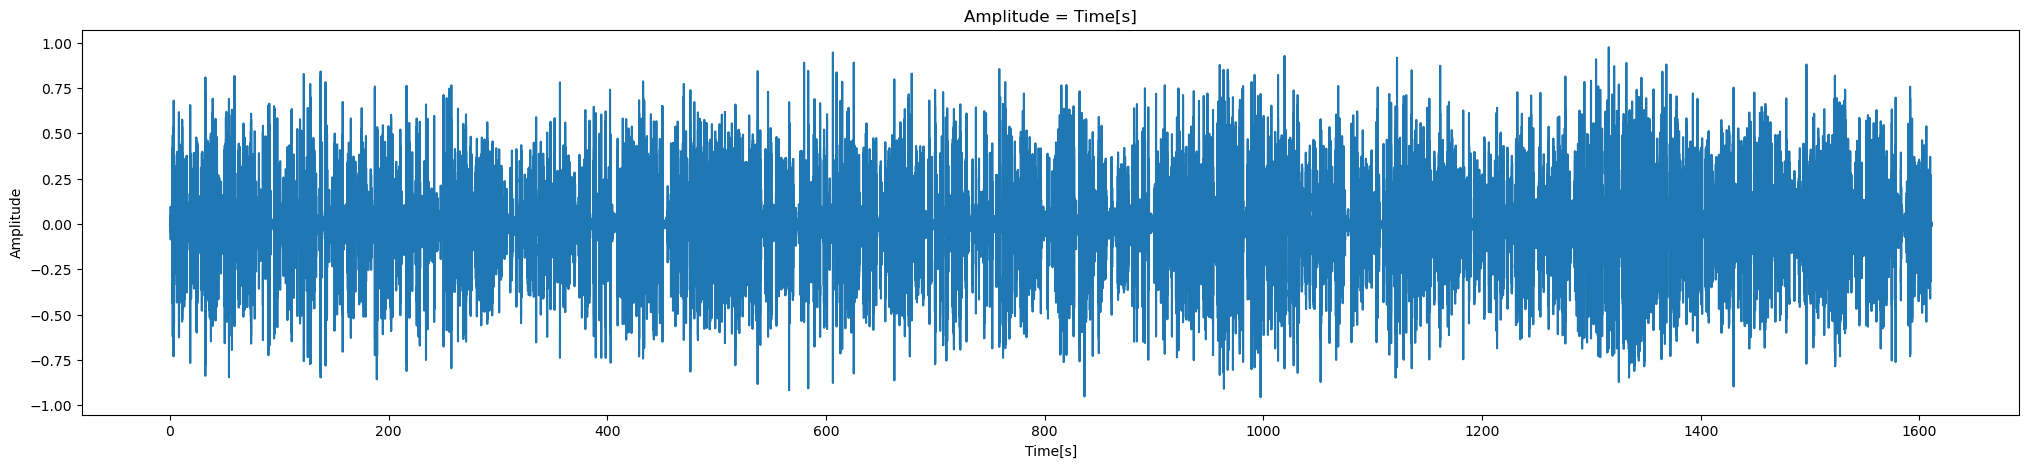

In [5]:
plt.figure(figsize=(25, 5))
plt.plot(time, input_audio)
# plt.xlim(0, 0.5*fs)
plt.ylabel('Amplitude')
plt.xlabel('Time[s]')
plt.title('Amplitude = Time[s]')
plt.show()

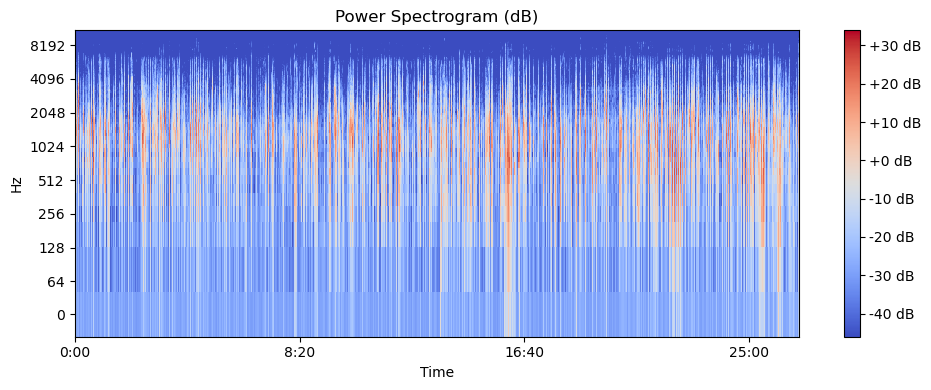

In [6]:
# plt.figure(figsize=(20, 5))
# plt.imshow(denoised_segments[0])

n_ffts = [1024, 2048]
hop_lengths = [128, 256, 512]

# for n_fft in n_ffts:

#   for hop_length in hop_lengths:

# Compute the power spectrogram
power_spec = librosa.feature.melspectrogram(y=input_audio, sr=sr, n_fft=2048, hop_length=512)

# Convert power spectrogram to dB scale
power_db = librosa.power_to_db(power_spec)

# Display the power spectrogram in dB
plt.figure(figsize=(10, 4))
librosa.display.specshow(power_db, sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Power Spectrogram (dB)')
plt.tight_layout()
plt.show()

/var/folders/_9/pgqcwl9j27v5p1f9b293n1vc0000gn/T/ipykernel_2582/3039600181.py:23: RuntimeWarning: divide by zero encountered in log10
  ax.plot_surface(T, F, 10 * np.log10(magnitude), cmap='inferno')
/var/folders/_9/pgqcwl9j27v5p1f9b293n1vc0000gn/T/ipykernel_2582/3039600181.py:29: RuntimeWarning: divide by zero encountered in log10
  surf = ax.plot_surface(T, F, 10 * np.log10(magnitude), cmap='inferno')
/Users/sehwan/opt/miniconda3/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py:180: RuntimeWarning: invalid value encountered in divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


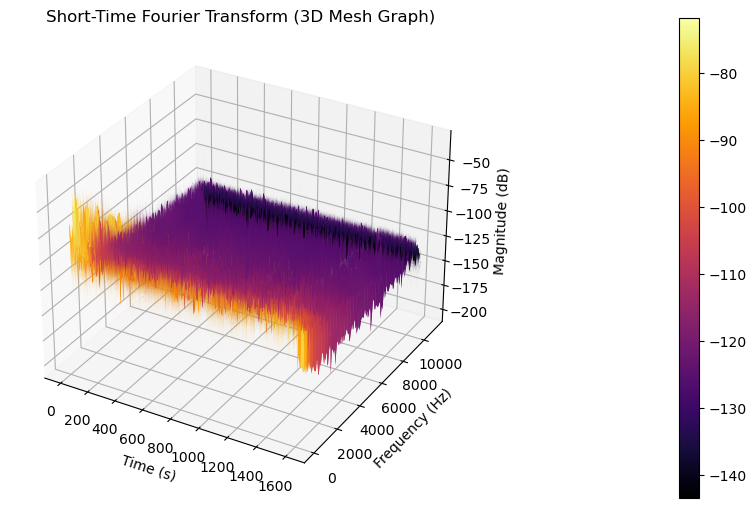

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from mpl_toolkits.mplot3d import Axes3D

# Generate a test signal
# duration = 5  # Duration of the signal in seconds
# fs = 44100  # Sampling rate
# t = np.linspace(0, duration, duration * fs, endpoint=False)
# f1 = 1000  # Frequency of the first sinusoid
# f2 = 4000  # Frequency of the second sinusoid
# x = np.sin(2 * np.pi * f1 * t) + 0.5 * np.sin(2 * np.pi * f2 * t)

# Compute the STFT
window_size = int(sr * 0.02)  # Size of the analysis window (20 ms)
hop_size = int(sr * 0.01)  # Hop size between consecutive windows (10 ms)
frequencies, times, magnitude = spectrogram(input_audio, fs=sr, window='hann', nperseg=window_size, noverlap=hop_size)

# Plot the STFT as a 3D mesh graph
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
T, F = np.meshgrid(times, frequencies)
ax.plot_surface(T, F, 10 * np.log10(magnitude), cmap='inferno')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
ax.set_zlabel('Magnitude (dB)')
ax.set_title('Short-Time Fourier Transform (3D Mesh Graph)')
# plt.colorbar()
surf = ax.plot_surface(T, F, 10 * np.log10(magnitude), cmap='inferno')

# Create a separate 2D plot for the colorbar
ax2 = fig.add_axes([0.95, 0.1, 0.02, 0.8])
plt.colorbar(surf, cax=ax2)

plt.show()

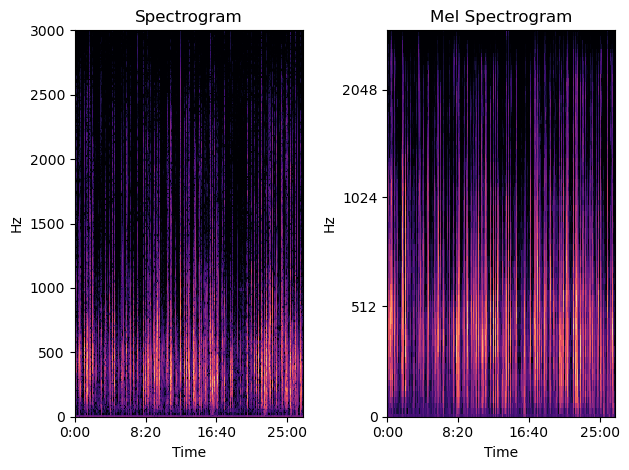

In [22]:
plt.subplot(121)
d_stft = np.abs(librosa.stft(input_audio))
librosa.display.specshow(librosa.amplitude_to_db(d_stft, ref=np.max), sr=sr, y_axis='linear', x_axis='time')
plt.title('Spectrogram')
plt.ylim(0, 3000)

plt.subplot(122)
d_msp = librosa.feature.melspectrogram(y=input_audio, sr=sr, n_mels=128)
librosa.display.specshow(librosa.power_to_db(d_msp, ref=np.max), sr=sr, y_axis='mel', x_axis='time')
plt.ylim(0, 3000)
plt.title('Mel Spectrogram')

plt.tight_layout()
plt.show()

In [25]:
data = input_audio
n_fft = 2048
hop = n_fft//4
fs = sr 

stft = librosa.stft(data, n_fft=n_fft, window='hann', hop_length=hop, center=True)
print('stft.shape', stft.shape)
# STFT 계산(출력차원: (n_fft//2) + 1 , T ) =(1025,13)
# T = (L - n_fft) // hop_length + 1(=구간개수=13)

# Mel Filter Bank 계수 계산
mel_f = librosa.filters.mel(sr=fs, n_fft=n_fft, n_mels=128)
print('mel_f.shape',mel_f.shape)

# 파워 스펙트럼 계산
power_spec = np.abs(stft)# ** 2

# Mel Spectrogram 계산
mel_spec = np.dot(mel_f, power_spec)#(128, 1025)X(1025, 13)
# 결과적으로 (128,13) 128개주파수로 필터링된 13시구간의 행렬
# 데이터가 총 멜 주파수 개수와 시간을 나눈 구간 개수의 곱으로 줄어들었다.(data reduction)
# 로그 스케일 변환
# log_mel_spec = librosa.amplitude_to_db(mel_spec)
log_mel_spec = 20*np.log10(mel_spec)
print('log_mel_spec.shape',log_mel_spec.shape)#(128,13)

n_mfcc = 20
mfcc = fft.dct(log_mel_spec, axis=0, norm='ortho')[:n_mfcc]
print('mfcc.shape',mfcc.shape)#(20, 13)

stft.shape (1025, 69378)
mel_f.shape (128, 1025)
log_mel_spec.shape (128, 69378)
mfcc.shape (20, 69378)


/var/folders/_9/pgqcwl9j27v5p1f9b293n1vc0000gn/T/ipykernel_2582/3341751590.py:24: RuntimeWarning: divide by zero encountered in log10
  log_mel_spec = 20*np.log10(mel_spec)


<function matplotlib.pyplot.show(close=None, block=None)>

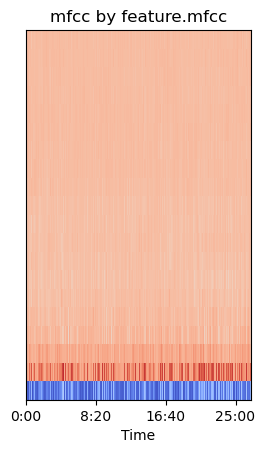

In [23]:
# data = two_tone
mfcc_f = librosa.feature.mfcc(y=input_audio, sr=sr, n_mfcc=20)
plt.subplot(122)
librosa.display.specshow(mfcc_f, x_axis='time', sr=sr)
plt.title('mfcc by feature.mfcc')
plt.show

In [26]:
import seaborn as sns
plt.figure(figsize=(15,6))
plt.subplot(121)
sns.heatmap(mfcc[::-1], center=0., cmap='coolwarm',annot=True)

mfcc_f = librosa.feature.mfcc(y=data, sr=fs, n_mfcc=n_mfcc)
plt.subplot(122)
sns.heatmap(mfcc_f[::-1], center=0., cmap='coolwarm', annot=True)

plt.show()

/Users/sehwan/opt/miniconda3/lib/python3.9/site-packages/matplotlib/colors.py:1354: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/Users/sehwan/opt/miniconda3/lib/python3.9/site-packages/matplotlib/colors.py:1355: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


In [12]:
import scipy.io.wavfile as wav
import numpy as np
from scipy.signal import find_peaks

def find_bowel_sound(audio_file):
    # 오디오 파일 로드
    sample_rate, audio_data = wav.read(audio_file)

    # 단일 채널 오디오를 모노로 변환
    if audio_data.ndim > 1:
        audio_data = audio_data[:, 0]

    # 정규화
    audio_data = audio_data / np.max(np.abs(audio_data))

    # Fourier 변환 수행
    audio_freq = np.fft.fft(audio_data)

    # 주파수 영역 설정
    freq_range = np.fft.fftfreq(len(audio_data), 1 / sample_rate)

    # 주파수 영역에서 0~500 Hz 범위의 인덱스 추출
    freq_indices = np.where((freq_range >= 0) & (freq_range <= 1000))[0]

    # 주파수 영역에서 0~500 Hz 범위의 신호만 추출
    audio_freq_filtered = audio_freq.copy()
    audio_freq_filtered[np.logical_not(np.isin(np.arange(len(freq_range)), freq_indices))] = 0

    # 역 Fourier 변환을 통해 주파수 영역에서 필터링된 신호를 시간 영역으로 변환
    audio_filtered = np.fft.ifft(audio_freq_filtered)

    # 신호의 절댓값 구하기
    abs_audio_filtered = np.abs(audio_filtered)

    # 신호의 피크 찾기
    peaks, _ = find_peaks(abs_audio_filtered, distance=sample_rate//4)

    # 피크가 발견되지 않은 경우
    if len(peaks) == 0:
        print("Bowel sound를 찾을 수 없습니다.")
        return None

    # 첫 번째 피크 위치 반환
    first_peak_position = peaks[0]

    # 피크 위치에서부터 1초 동안의 오디오 데이터 추출
    bowel_sound = audio_data[first_peak_position:first_peak_position + sample_rate]

    return bowel_sound, audio_data, sample_rate, first_peak_position

# 오디오 파일 경로
audio_file_path = "/Users/sehwan/Desktop/datasets/bowel_sound/output.wav"

# Bowel sound 찾기
bowel_sound, audio_data, sample_rate, first_peak_position = find_bowel_sound(audio_file_path)

# 결과 출력
print("Bowel sound:", bowel_sound)


Bowel sound: [ 0.          0.          0.         ... -0.00319319 -0.004915
 -0.00604201]


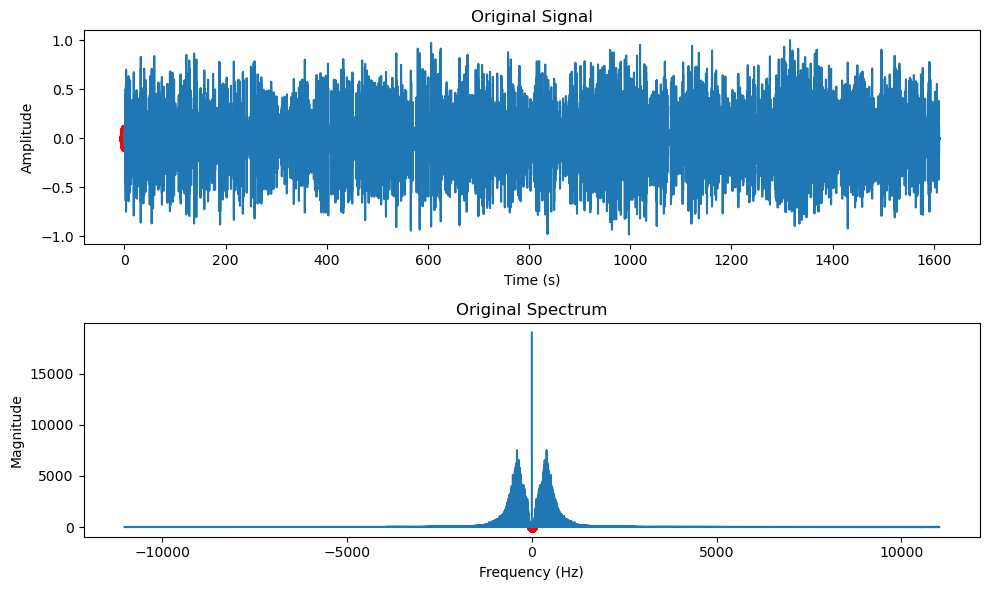

In [13]:

# 시간 영역 플롯
time = np.arange(len(audio_data)) / sample_rate
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(time, audio_data, label="Original Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Original Signal")

# 주파수 영역 플롯
freq_range = np.fft.fftfreq(len(audio_data), 1 / sample_rate)
audio_freq = np.fft.fft(audio_data)
plt.subplot(2, 1, 2)
plt.plot(freq_range, np.abs(audio_freq), label="Original Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Original Spectrum")

# Bowel sound 표시
bowel_time = np.arange(len(bowel_sound)) / sample_rate + first_peak_position / sample_rate
bowel_freq_range = freq_range[:len(bowel_sound)]
bowel_freq = np.fft.fft(bowel_sound)
plt.subplot(2, 1, 1)
plt.scatter(bowel_time, bowel_sound, color='red', label="Bowel Sound")
plt.subplot(2, 1, 2)
plt.scatter(bowel_freq_range, np.abs(bowel_freq), color='red', label="Bowel Sound Spectrum")

plt.tight_layout()
plt.show()


In [18]:
# find indices where MFCC values are above 200dB
indices = np.where(mfcc > 200)

# # get the indices as a 1D array
# indices = indices[0]

# print(indices)
print(indices)

(array([1, 1, 1, ..., 1, 1, 1]), array([  109,   131,   132, ..., 69181, 69278, 69331]))


In [19]:
import numpy as np
import librosa

# Load bowel sound audio data
# audio_data, sr = librosa.load('bowel_sound.wav', sr=None)

# # Compute the STFT
# window_size = int(sr * 0.02)  # Size of the analysis window (20 ms)
# hop_size = int(sr * 0.01)  # Hop size between consecutive windows (10 ms)
# # frequencies, times, magnitude = librosa.stft(input_audio, n_fft=window_size, hop_length=hop_size)
# frequencies, times, magnitude = spectrogram(input_audio, fs=sr, window='hann', nperseg=window_size, noverlap=hop_size)


# Set the threshold values for Bowel sound detection
frequency_threshold = 0  # Minimum frequency threshold (Hz)
magnitude_threshold = 50  # Minimum magnitude threshold (dB)

# Initialize an empty list to store the detected Bowel sound segments
bowel_sound_segments = []

# Iterate over the STFT magnitude spectrogram
for i in range(magnitude.shape[1]):
    # Extract the magnitude values for the current time frame
    frame_magnitude = magnitude[:, i]

    # Check if the magnitude exceeds the threshold
    if np.max(frame_magnitude) >= magnitude_threshold:
        # Find the index of the maximum magnitude value
        max_magnitude_index = np.argmax(frame_magnitude)

        # Get the corresponding frequency value
        max_magnitude_frequency = frequencies[max_magnitude_index]

        # Check if the frequency exceeds the threshold
        if max_magnitude_frequency >= frequency_threshold:
            # Add the current time frame to the detected Bowel sound segments
            bowel_sound_segments.append(times[i])

# Print the detected Bowel sound segments
for segment in bowel_sound_segments:
    print(f"Bowel sound detected at time {segment} seconds.")


In [34]:
segment_samples, num_segments, len(times)

(220500, 0, 160727)

In [28]:
segments = np.array_split(magnitude, num_segments, axis=1)
times_segments = np.array_split(times, num_segments)

ValueError: ignored

In [ ]:
# Load the audio file
def load_audio(file_path, sample_rate=22050):
    audio, sr = librosa.load(file_path, sr=sample_rate)
    return audio, sr

# Preprocess the audio
def preprocess_audio(audio, sample_rate):
    # Convert audio to mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=2048, hop_length=1024, win_length=2048, window='hann')

    # Apply log-scale to the mel spectrogram
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Normalize the mel spectrogram
    mel_spec_db_norm = (mel_spec_db - mel_spec_db.mean()) / mel_spec_db.std()

    return mel_spec_db_norm

# Apply lowpass filter to the mel spectrogram
def apply_lowpass_filter(signal_waveform, sample_rate):
    # nyquist_freq = sample_rate / 2
    # normalized_cutoff = cutoff_freq / nyquist_freq
    # b, a = scipy.signal.butter(5, normalized_cutoff, btype='lowpass')
    # filtered_mel_spec = scipy.signal.lfilter(b, a, mel_spec)
    # return filtered_mel_spec

    # Design the Butterworth filter
    highest_freq = 2048  # Highest frequency in Hz
    smallest_freq = 512  # Smallest frequency in Hz
    nyquist_freq = 0.5 * sample_rate
    normalized_highest_freq = highest_freq / nyquist_freq
    normalized_smallest_freq = smallest_freq / nyquist_freq
    b, a = signal.butter(4, [normalized_smallest_freq, normalized_highest_freq], btype='band', analog=False, output='ba')

    # Apply the Butterworth filter to the signal
    filtered_signal = signal.lfilter(b, a, signal_waveform)
    return filtered_signal


# Denoise the mel spectrogram using a pre-trained model
def denoise_mel_spectrogram(mel_spec):
    # Load the pre-trained denoising model
    model = tf.keras.models.load_model('denoising_model.h5')

    # Expand dimensions for model input
    mel_spec_input = np.expand_dims(mel_spec, axis=0)

    # Predict denoised mel spectrogram
    denoised_mel_spec = model.predict(mel_spec_input)

    return denoised_mel_spec[0]

# Convert mel spectrogram back to audio
def mel_to_audio(mel_spec, sample_rate):
    # Inverse of log-scale on mel spectrogram
    mel_spec = librosa.db_to_power(mel_spec)

    # Convert mel spectrogram to audio
    audio = librosa.feature.inverse.mel_to_audio(mel_spec, sr=sample_rate)

    return audio

# Divide audio into 1-minute segments
def divide_audio(audio, sample_rate, segment_length=60):
    segment_samples = segment_length * sample_rate
    num_segments = len(audio) // segment_samples
    segments = np.array_split(audio[:num_segments * segment_samples], num_segments)
    return segments


# def build_denoising_autoencoder2(input_shape):
#     # model = tf.keras.Sequential()
#     inputs = tf.keras.Input(shape=input_shape)

#     # Convolutional layers
#     x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
#     x = tf.keras.layers.MaxPooling2D((2, 2))(x)
#     x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
#     x = tf.keras.layers.MaxPooling2D((2, 2))(x)

#     # Upsampling layers
#     x = tf.keras.layers.Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
#     x = tf.keras.layers.UpSampling2D((2, 2))(x)
#     x = tf.keras.layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
#     x = tf.keras.layers.UpSampling2D((2, 2))(x)
#     x = tf.keras.layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

#     # Output layer
#     # x = tf.keras.layers.Conv2D(1, (3, 3), activation='linear', padding='same')(x)

#     model = tf.keras.Model(inputs=inputs, outputs=x)

#     return model

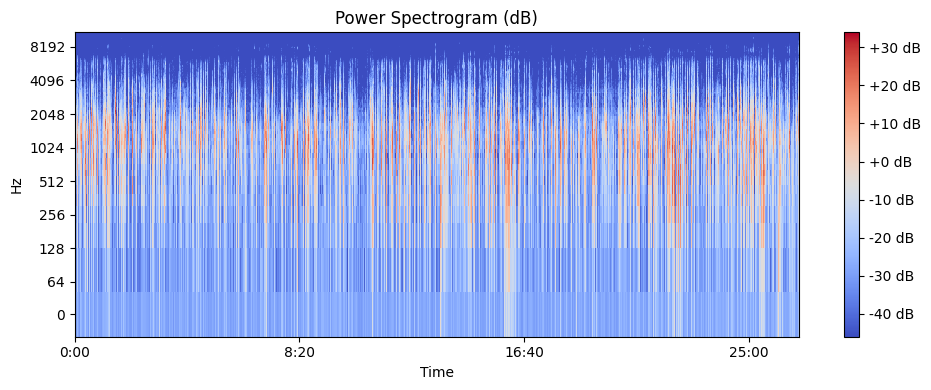

In [ ]:
# Compute the power spectrogram
power_spec = librosa.feature.melspectrogram(y=input_audio, sr=sr, n_fft=2048, hop_length=512)

# Convert power spectrogram to dB scale
power_db = librosa.power_to_db(power_spec)

# Display the power spectrogram in dB
plt.figure(figsize=(10, 4))
librosa.display.specshow(power_db, sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Power Spectrogram (dB)')
plt.tight_layout()
plt.show()

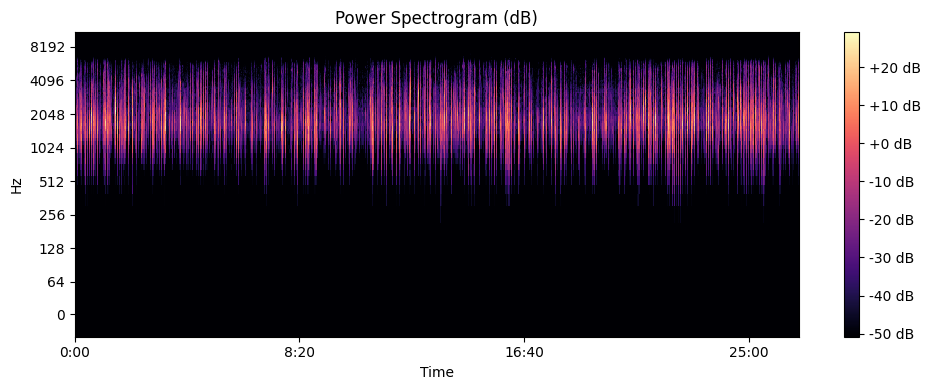

In [ ]:

# Compute the power spectrogram
power_spec = librosa.feature.melspectrogram(y=apply_lowpass_filter(input_audio, sr), sr=sr, n_fft=2048, hop_length=512)

# Convert power spectrogram to dB scale
power_db = librosa.power_to_db(power_spec)

# Display the power spectrogram in dB
plt.figure(figsize=(10, 4))
librosa.display.specshow(power_db, sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Power Spectrogram (dB)')
plt.tight_layout()
plt.show()

In [ ]:
x = apply_lowpass_filter(input_audio, sr)

0 --------> 0.0006574917648551901


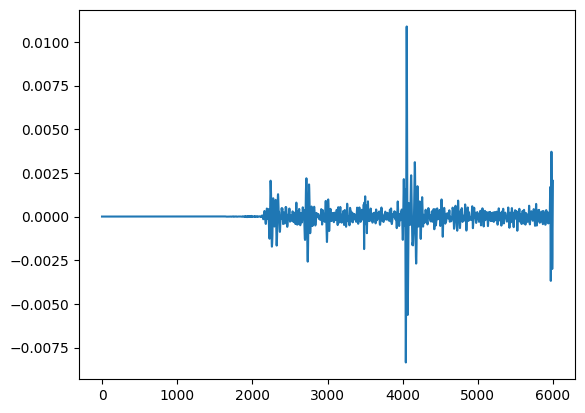

1 --------> 0.004270771620776778


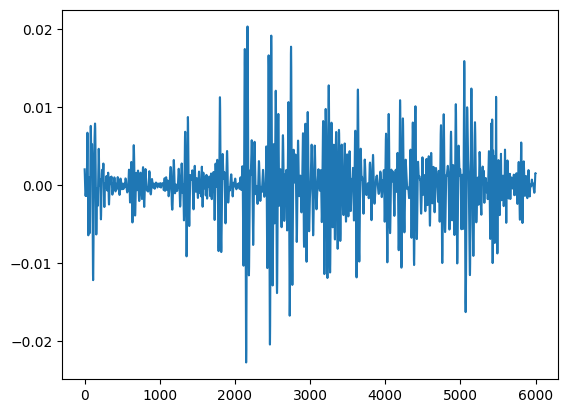

2 --------> 0.006205660340960884


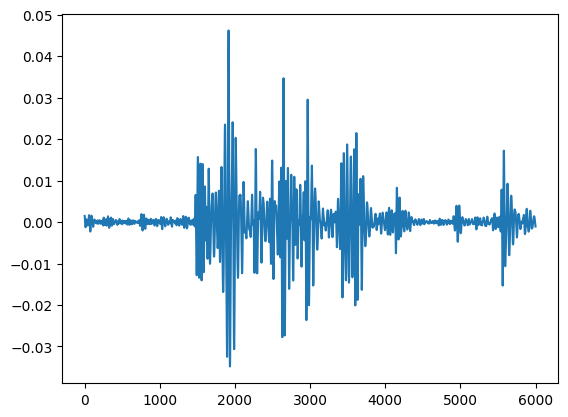

3 --------> 0.002507496034903177


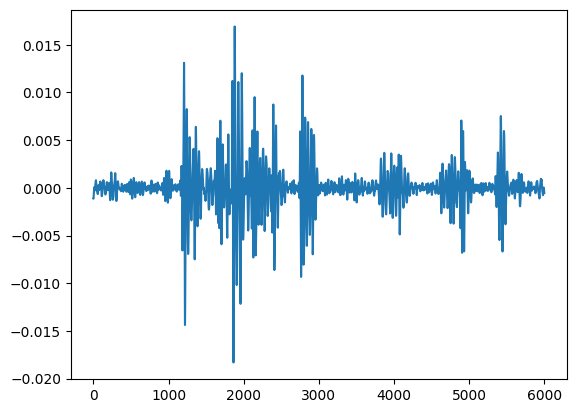

4 --------> 0.00111127326480291


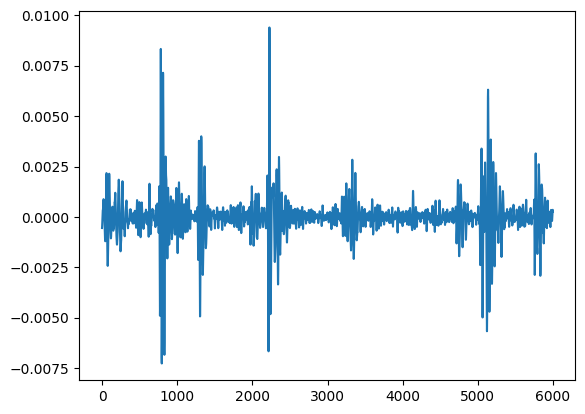

5 --------> 0.0007877633549293614


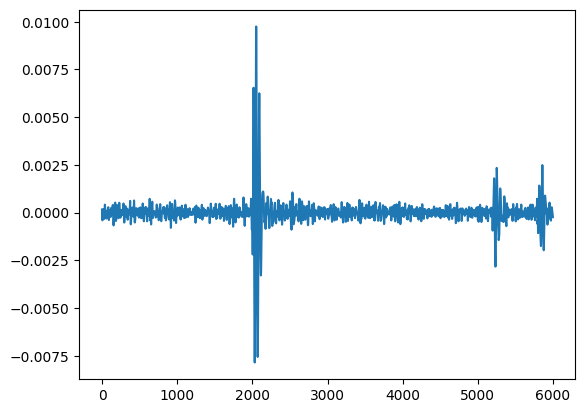

6 --------> 0.0025328562605449684


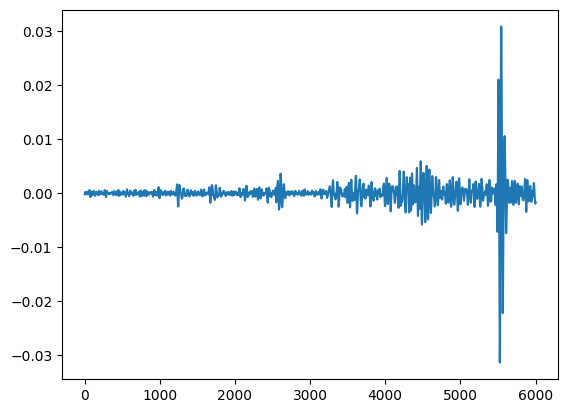

7 --------> 0.012703813606910298


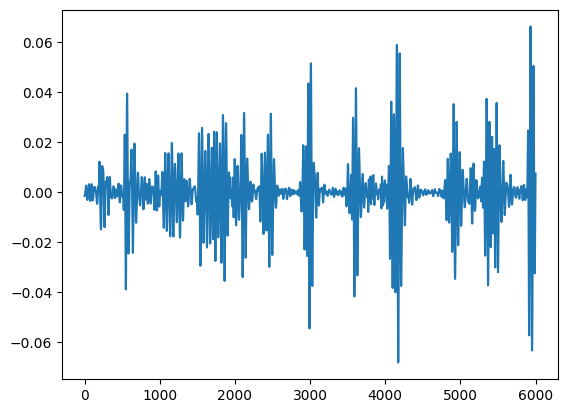

8 --------> 0.016699326522081368


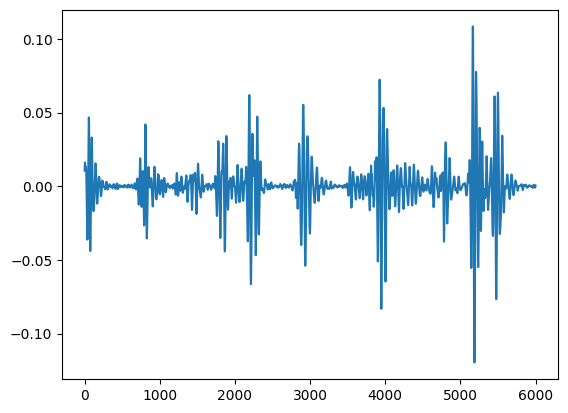

9 --------> 0.019586433517102105


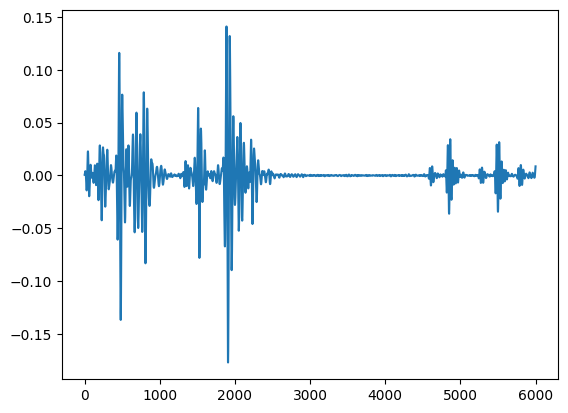

10 --------> 0.004894110152713054


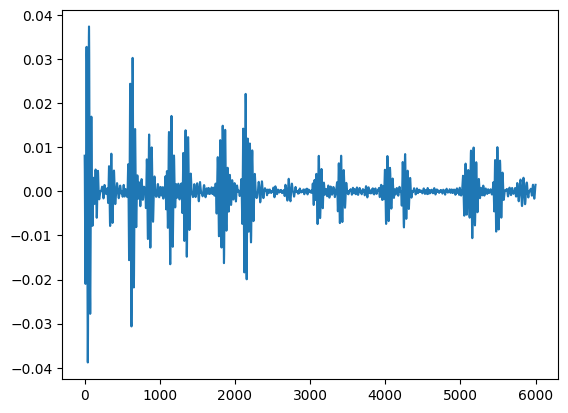

11 --------> 0.05298181400890766


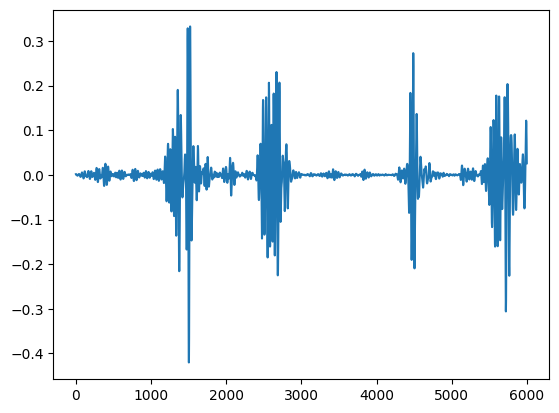

12 --------> 0.05506262788559583


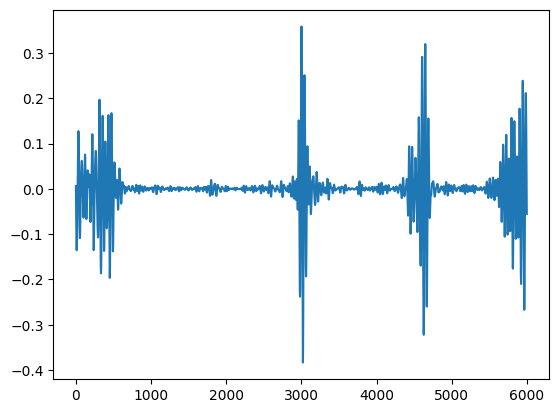

13 --------> 0.06930444728255557


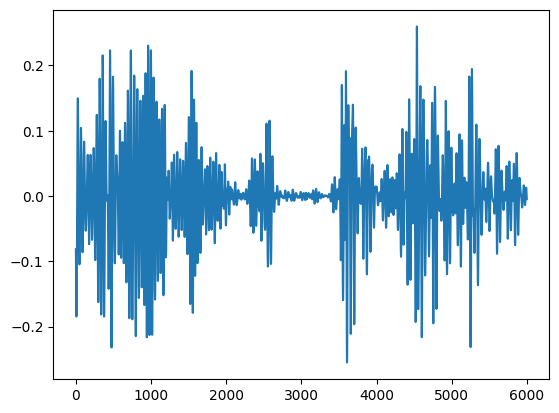

14 --------> 0.02947668543274036


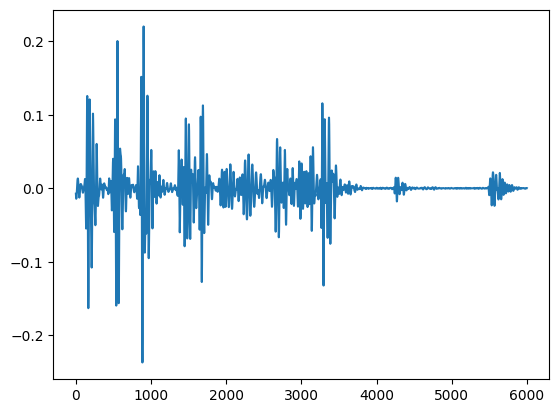

15 --------> 0.0018701514933213027


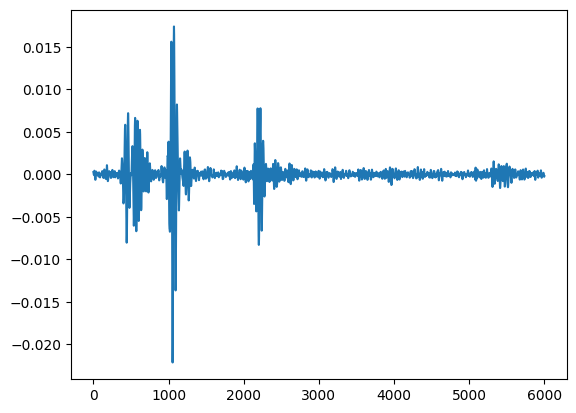

16 --------> 0.0002771702916048381


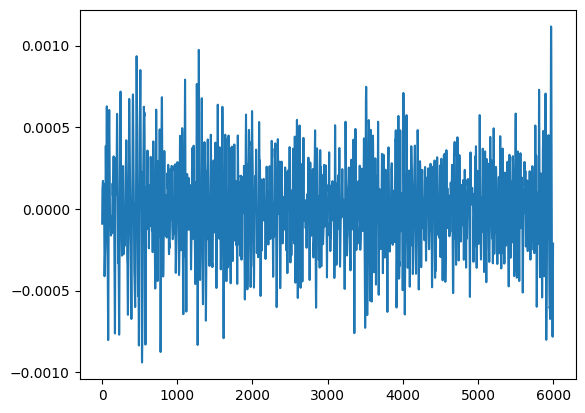

17 --------> 0.00035179046904219207


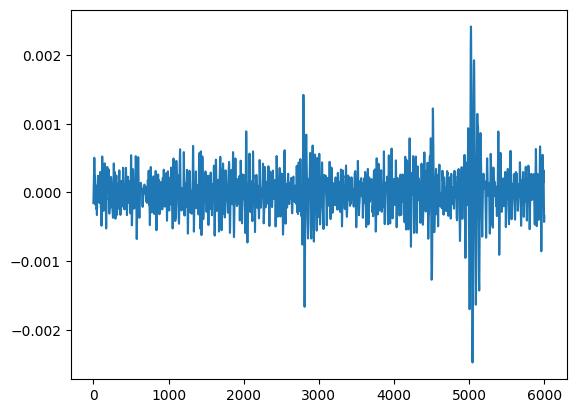

18 --------> 0.0017264652090181482


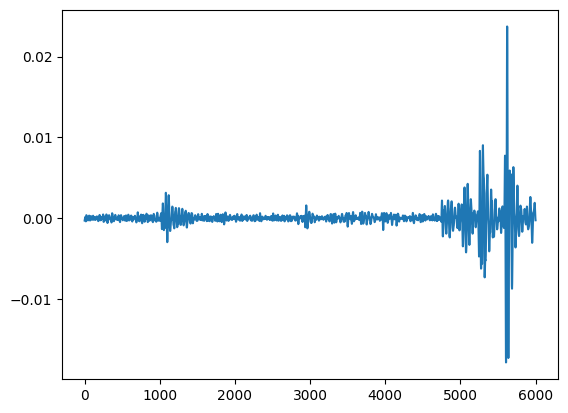

19 --------> 0.001050144557339113


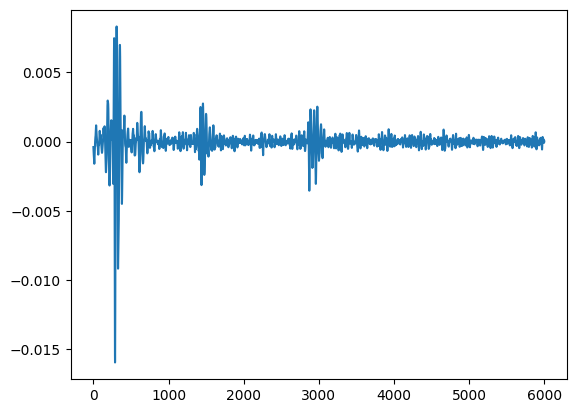

20 --------> 0.0002915243381432503


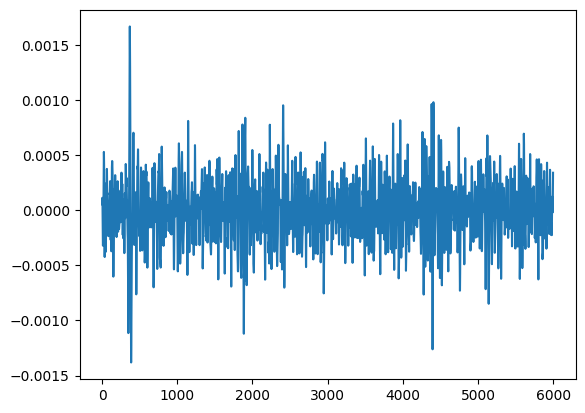

21 --------> 0.0038878516089422208


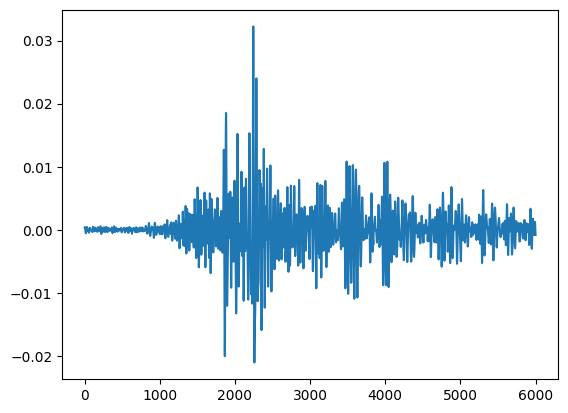

22 --------> 0.003052203946178105


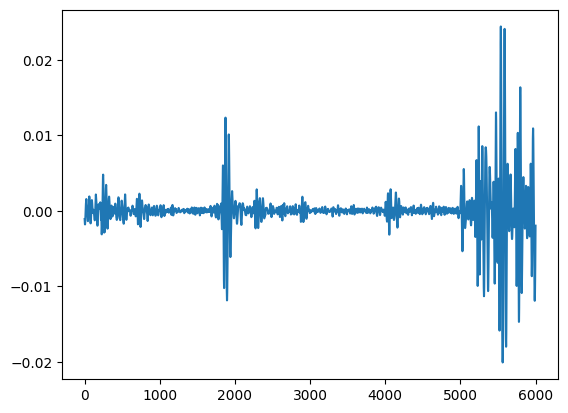

23 --------> 0.019253822715853963


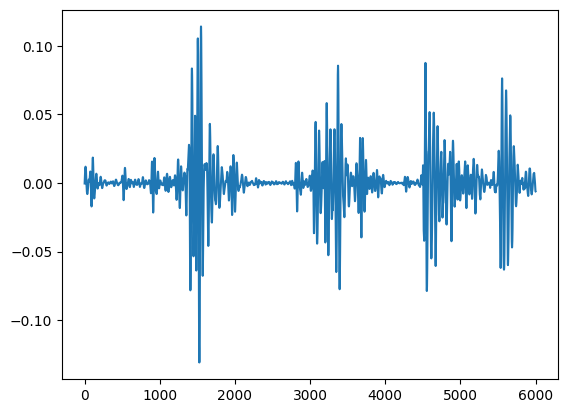

24 --------> 0.02291202289833136


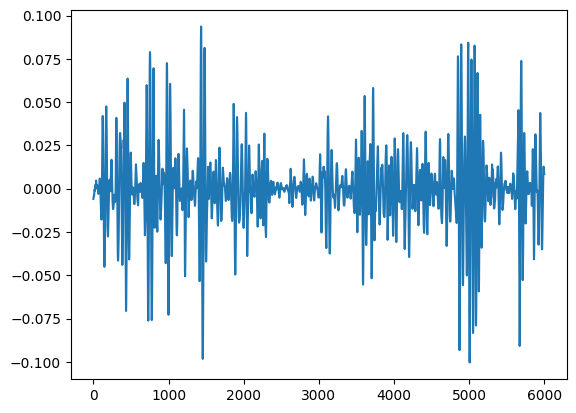

25 --------> 0.02485786931971378


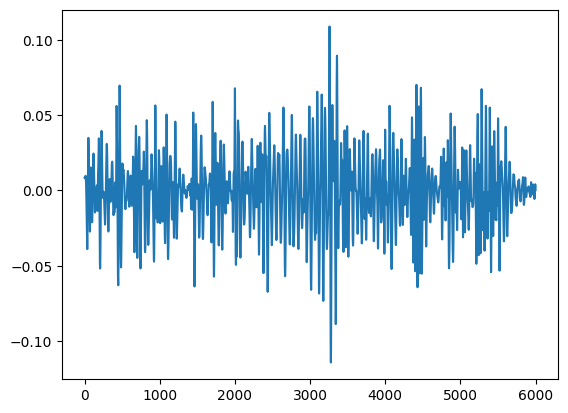

26 --------> 0.013527948996333094


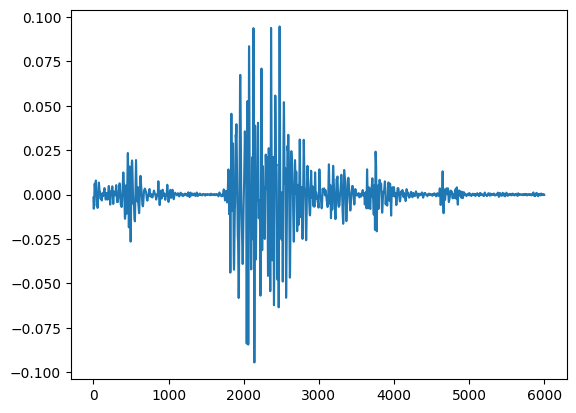

27 --------> 0.0005305125388480743


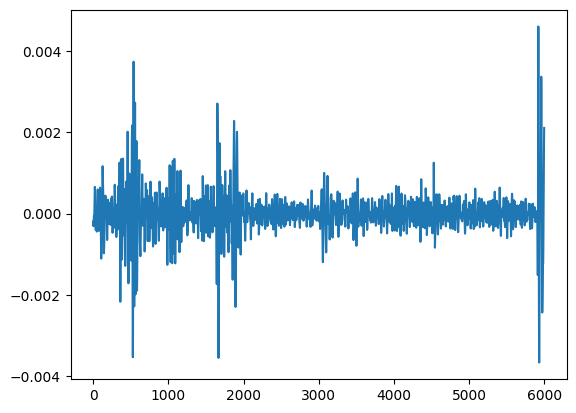

28 --------> 0.002954299529466314


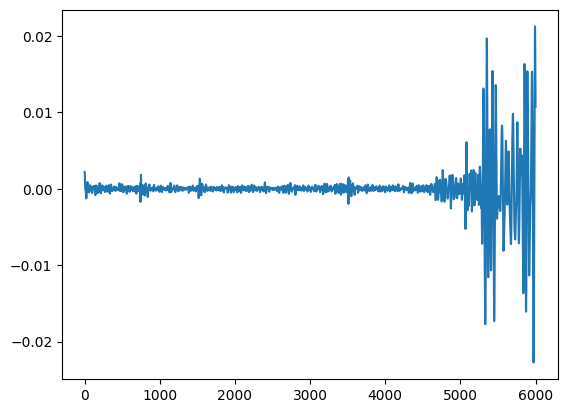

29 --------> 0.007463566078632573


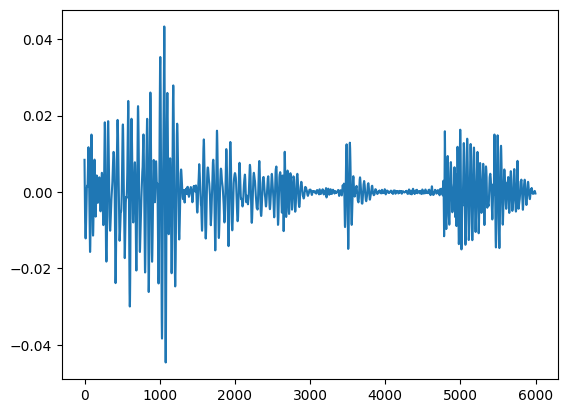

30 --------> 0.1280590041319781


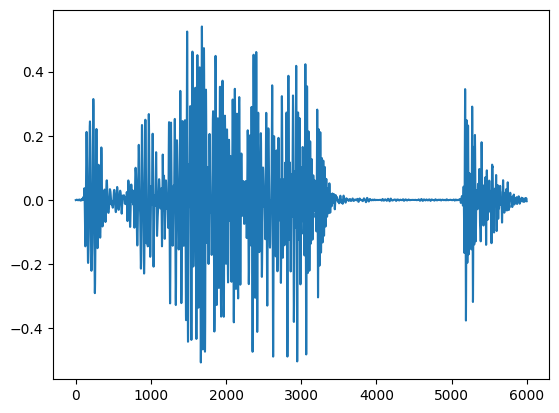

31 --------> 0.00917547152374026


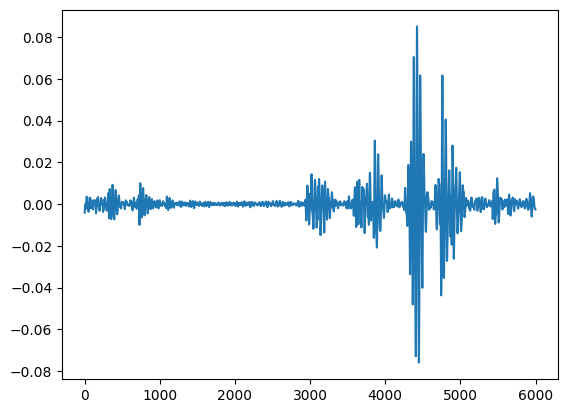

32 --------> 0.015355627394312182


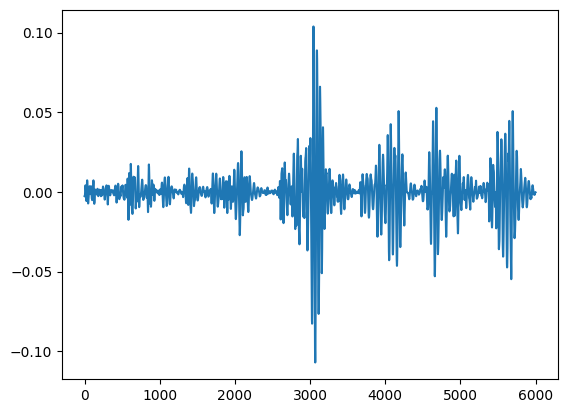

33 --------> 0.008725508042003423


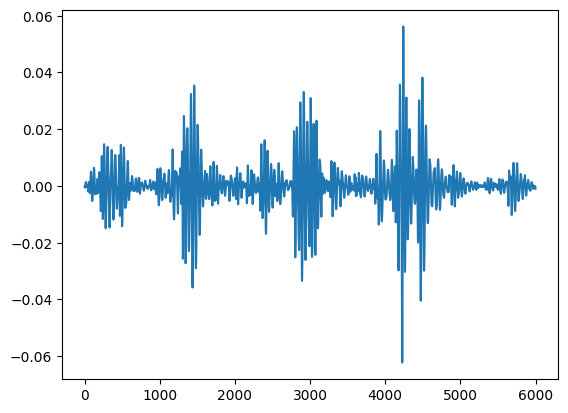

34 --------> 0.0018878628650144404


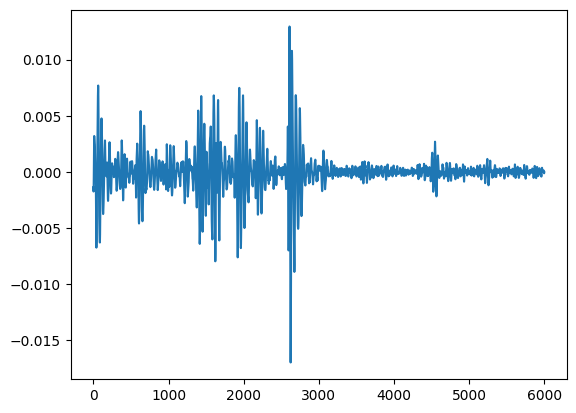

35 --------> 0.003569627284302082


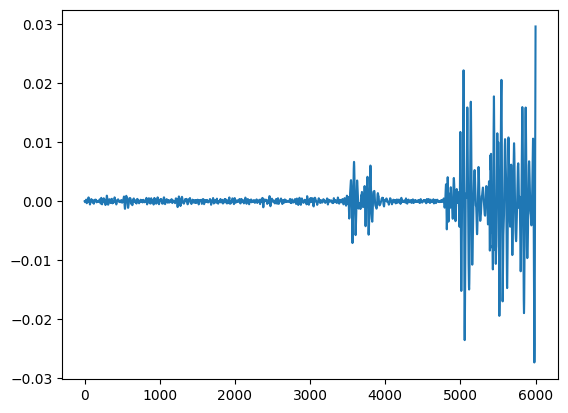

36 --------> 0.020488108086660257


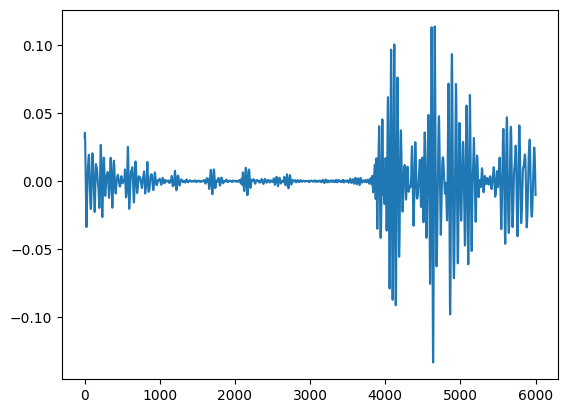

37 --------> 0.00860883640809776


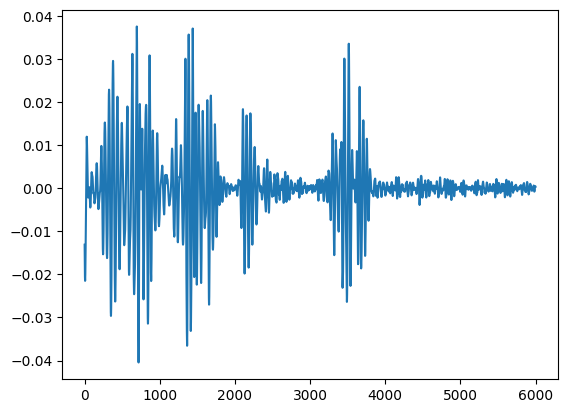

38 --------> 0.0012044278291373166


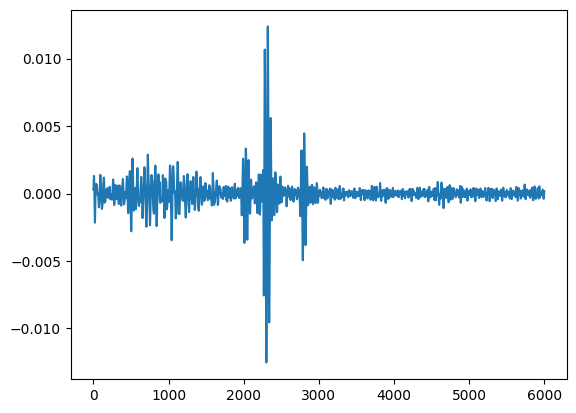

39 --------> 0.0020390321165023894


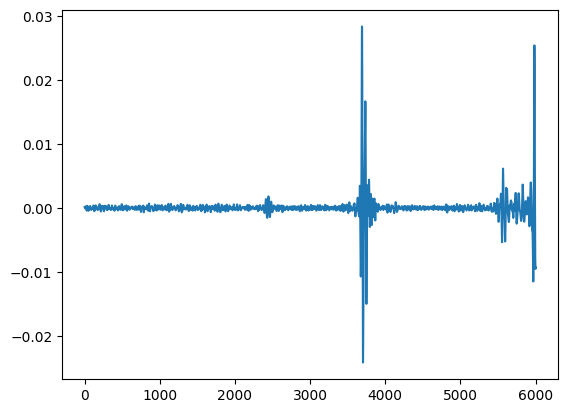

40 --------> 0.033264295595877416


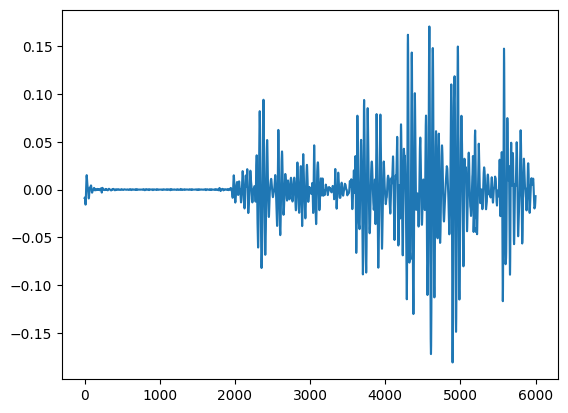

41 --------> 0.047932248865465626


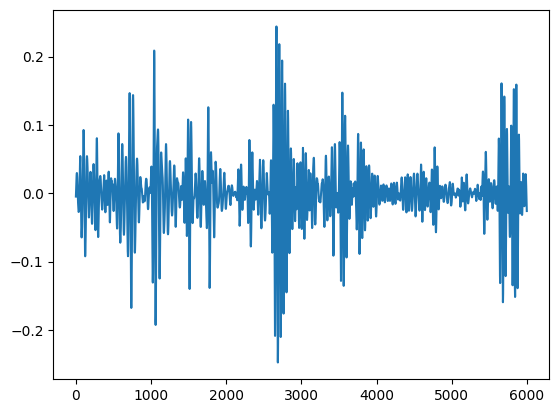

42 --------> 0.03221158955890064


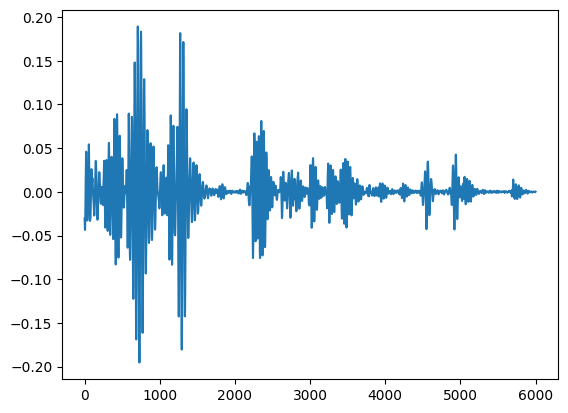

43 --------> 0.009467554019017143


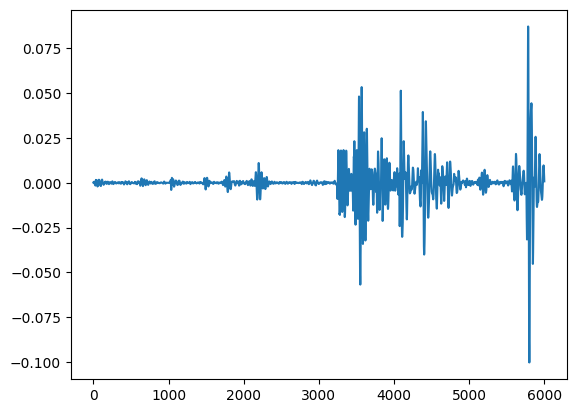

44 --------> 0.011205125440925785


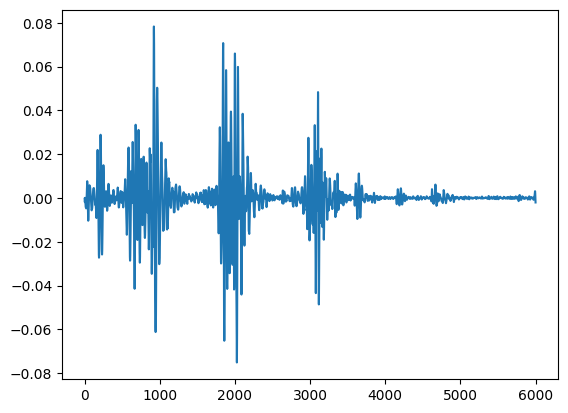

45 --------> 0.0019364741992429796


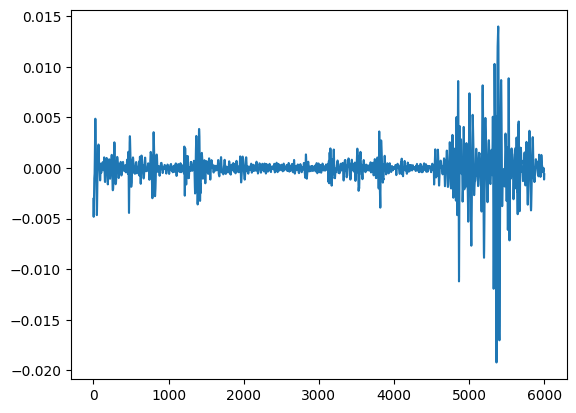

46 --------> 0.010565072973961424


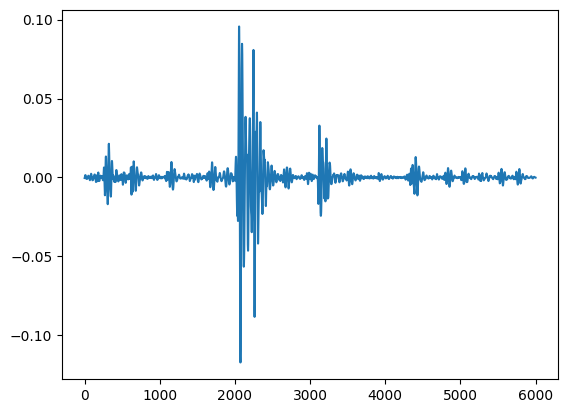

47 --------> 0.025549859846926905


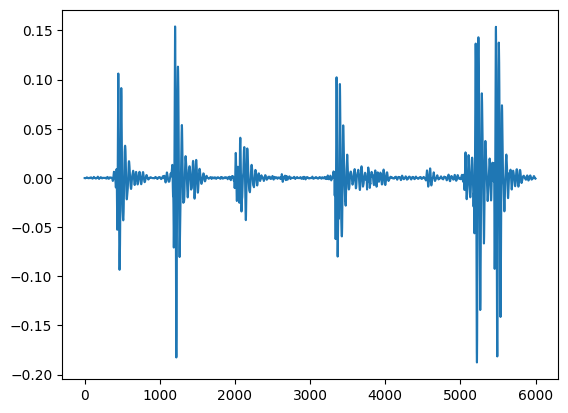

48 --------> 0.017317888846101123


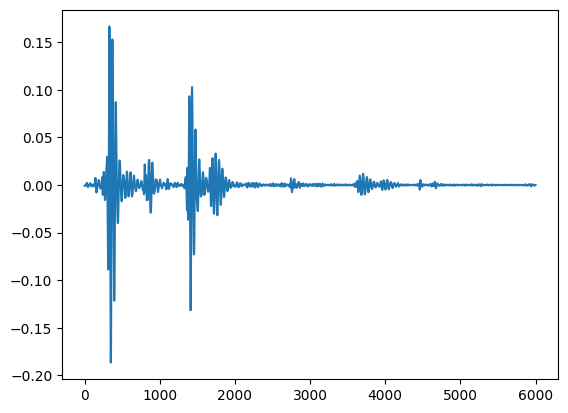

49 --------> 0.0010422423397215598


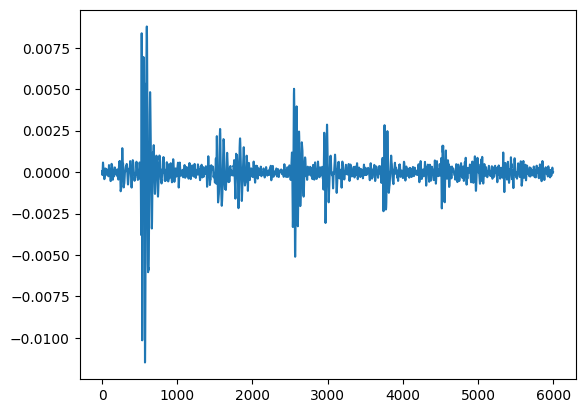

50 --------> 0.0013831676954099434


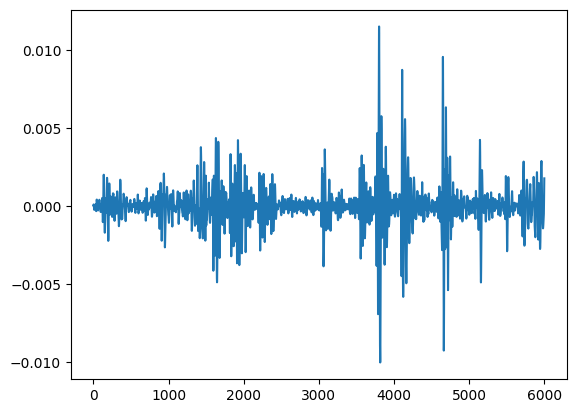

51 --------> 0.0013293360646015142


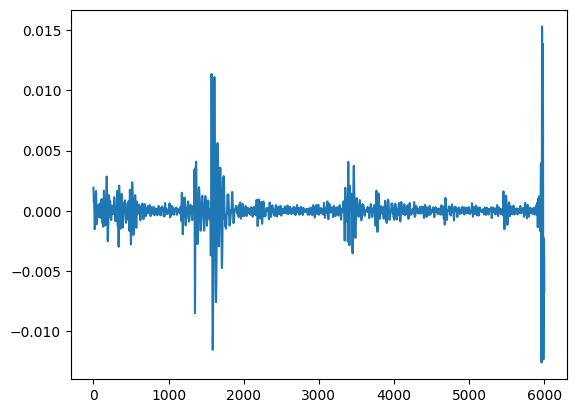

52 --------> 0.0020768832153887124


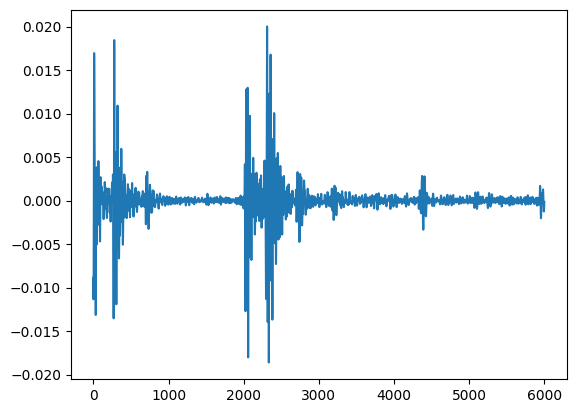

53 --------> 0.0007824337904198516


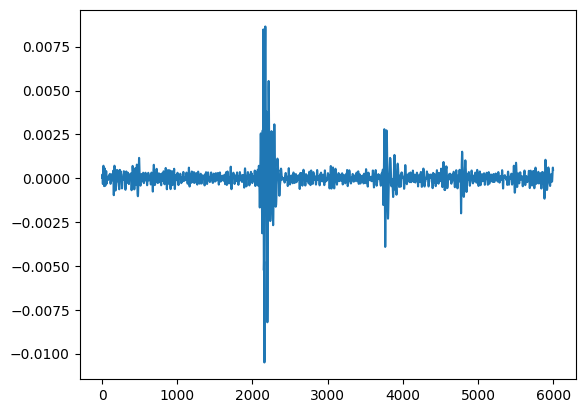

54 --------> 0.0009075428255572104


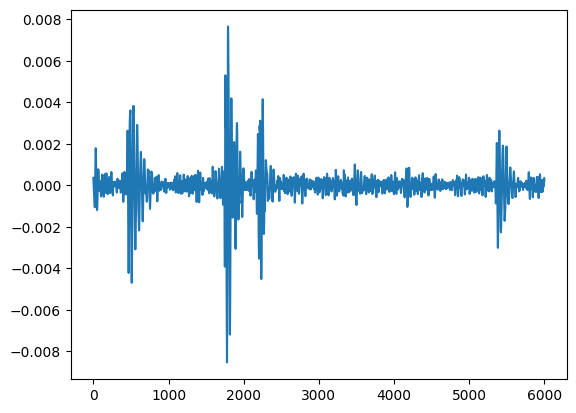

55 --------> 0.021306551341850753


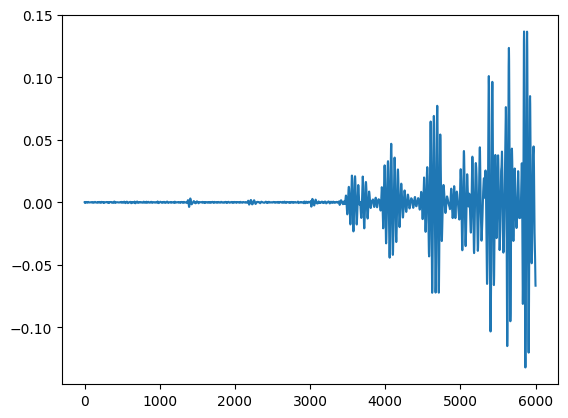

56 --------> 0.06483899305403018


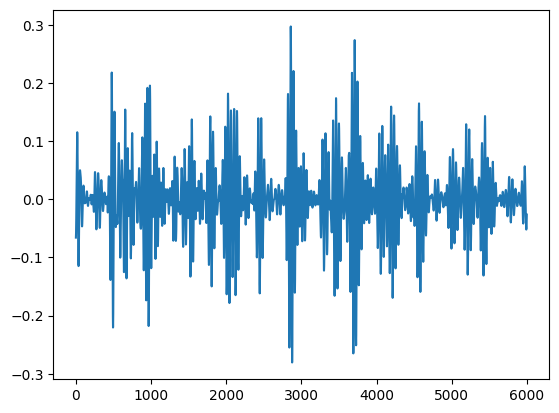

57 --------> 0.01285126130034593


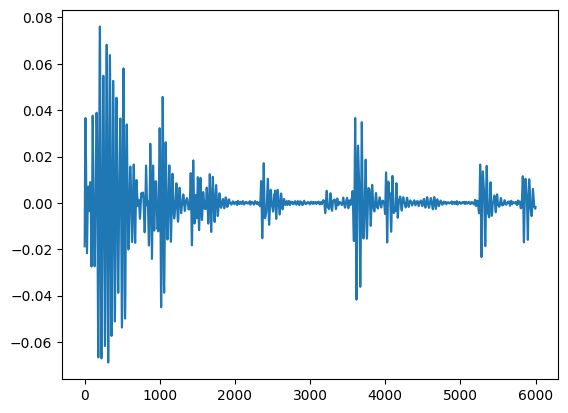

58 --------> 0.007189061440784238


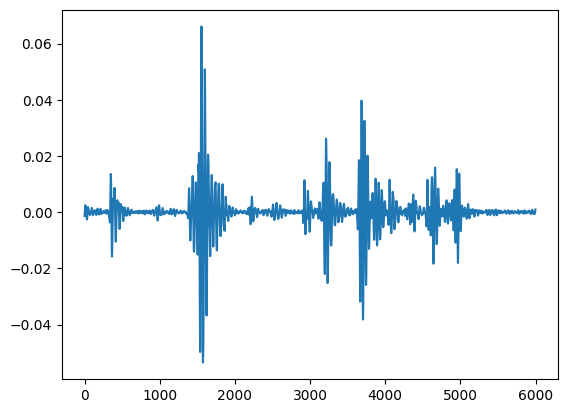

59 --------> 0.003119131182364467


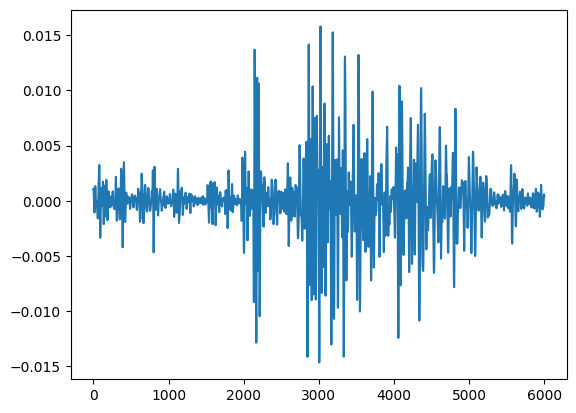

60 --------> 0.003577282784248676


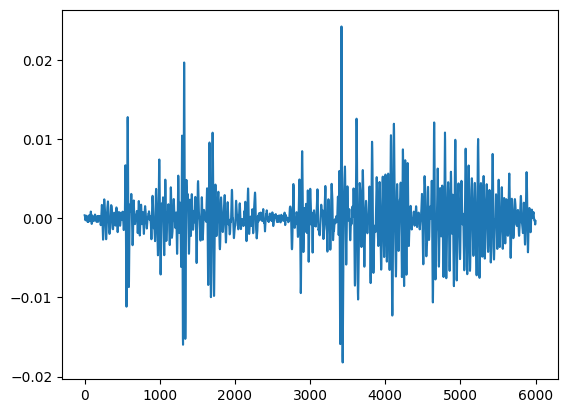

61 --------> 0.0016006891247911106


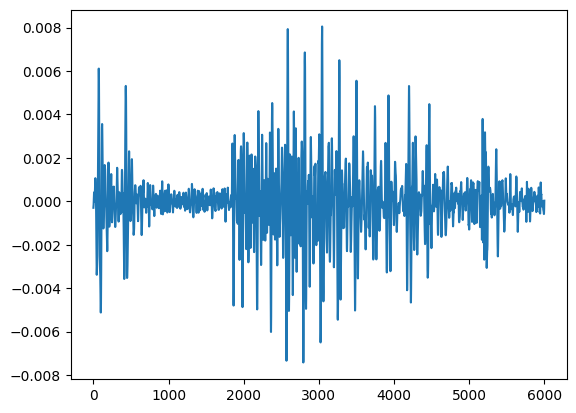

62 --------> 0.0013743789261276562


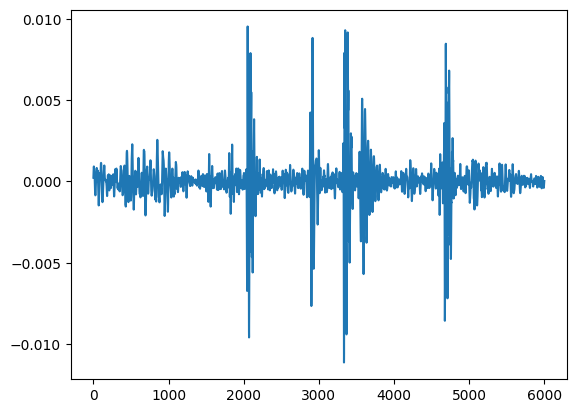

63 --------> 0.0006138834710804761


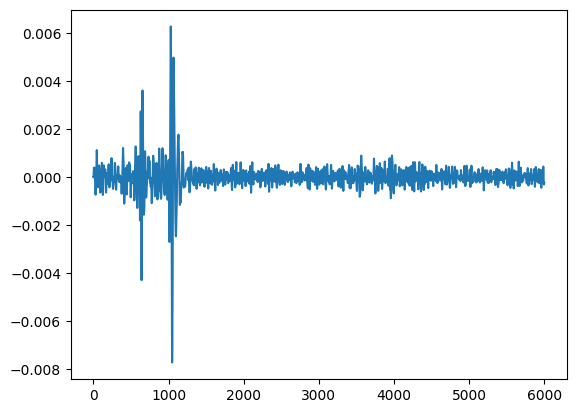

64 --------> 0.0016097382293269256


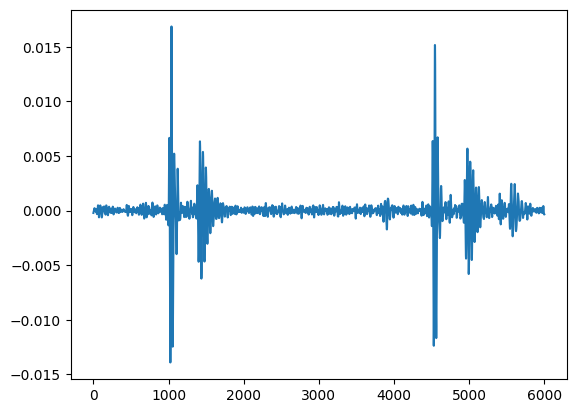

65 --------> 0.0016855853456827412


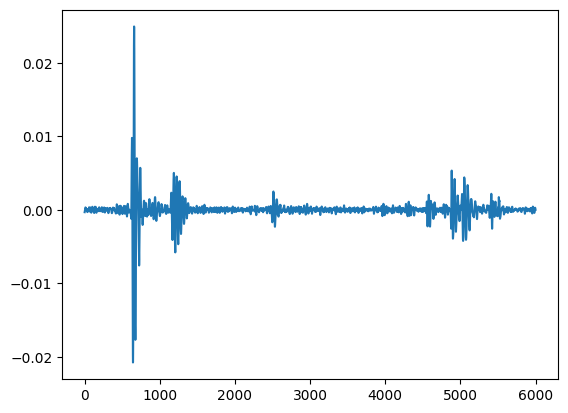

66 --------> 0.000712057828968627


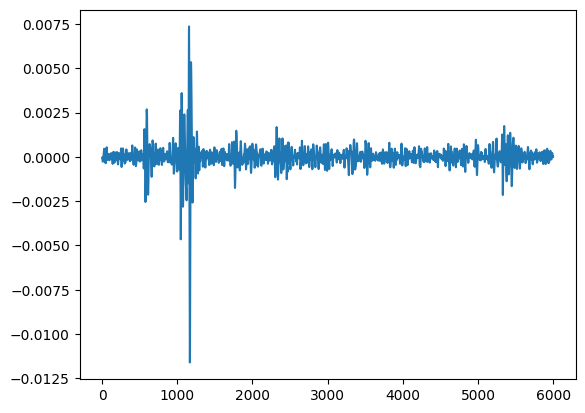

67 --------> 0.017158253311785405


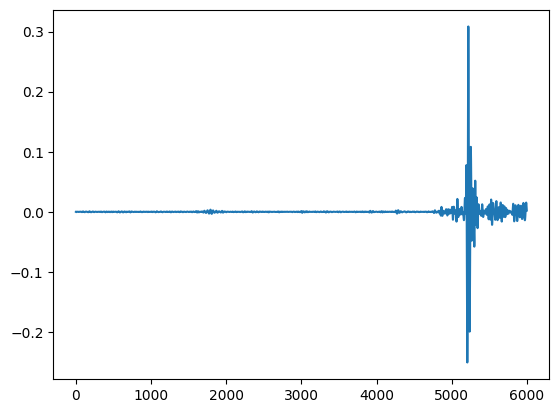

68 --------> 0.04421527934116694


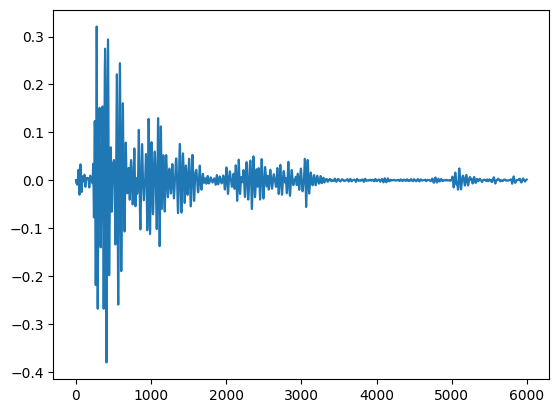

69 --------> 0.005128461578136385


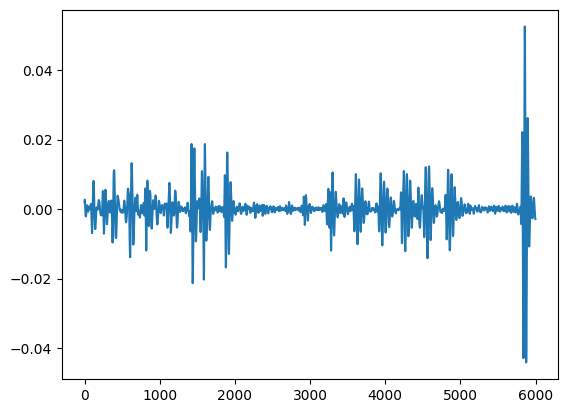

70 --------> 0.02457170948632868


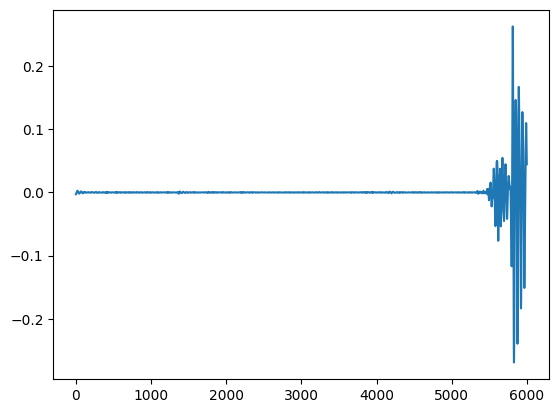

71 --------> 0.05020744388357052


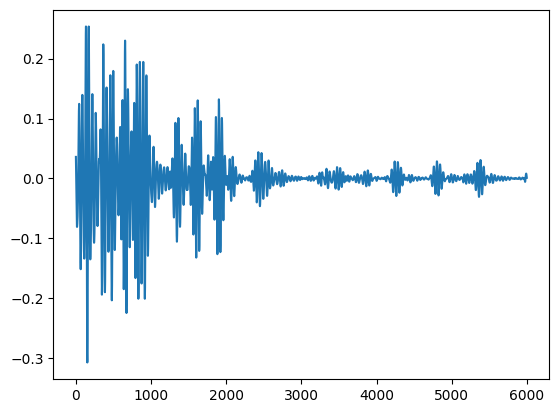

72 --------> 0.0027494414107349643


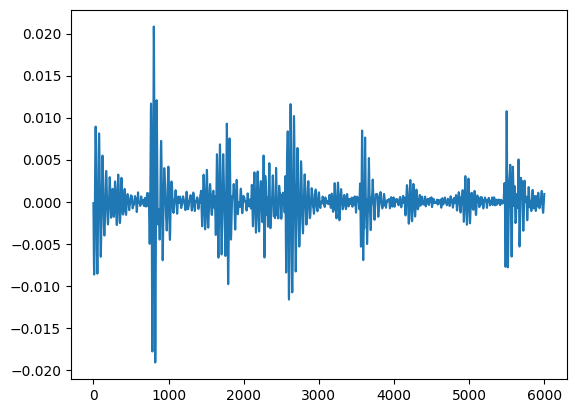

73 --------> 0.005320112295224227


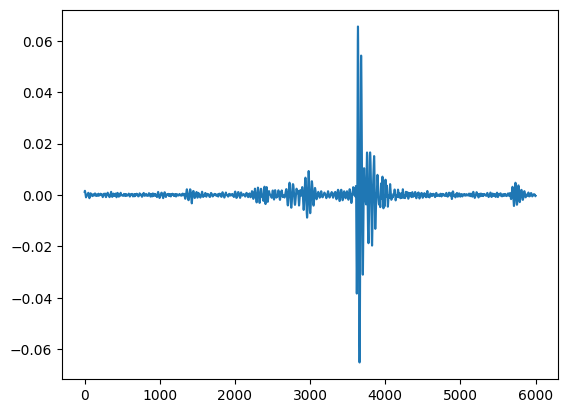

74 --------> 0.0010216004749224548


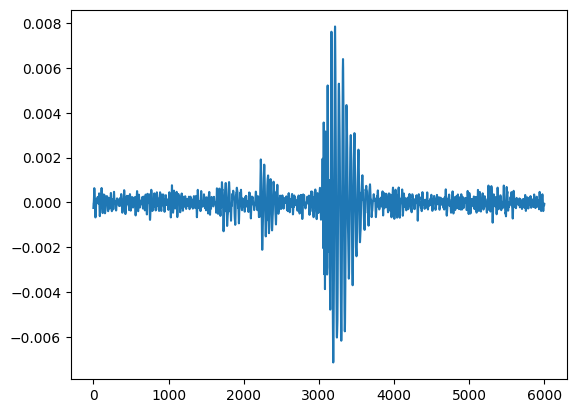

75 --------> 0.0004976576482927516


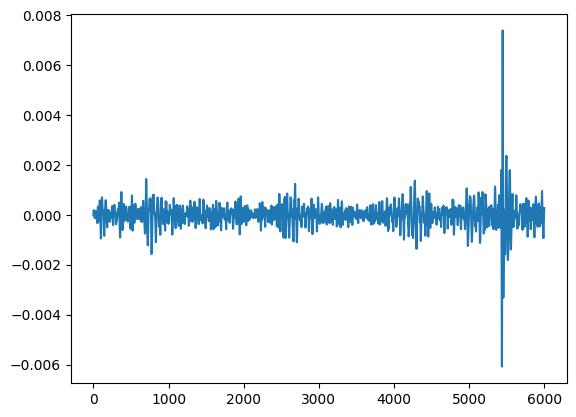

76 --------> 0.001086095506768431


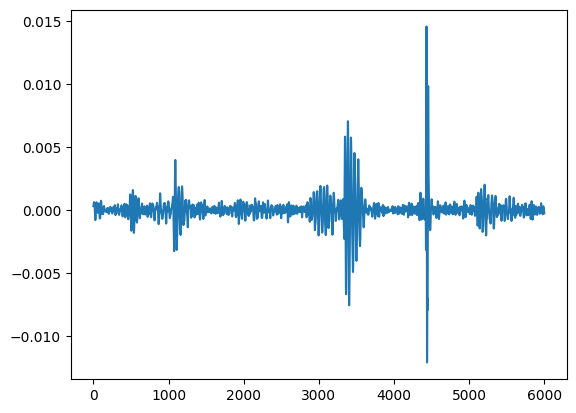

77 --------> 0.0031652756077517313


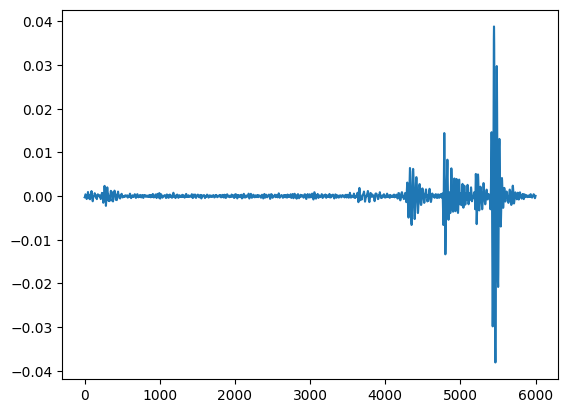

78 --------> 0.000670001449102469


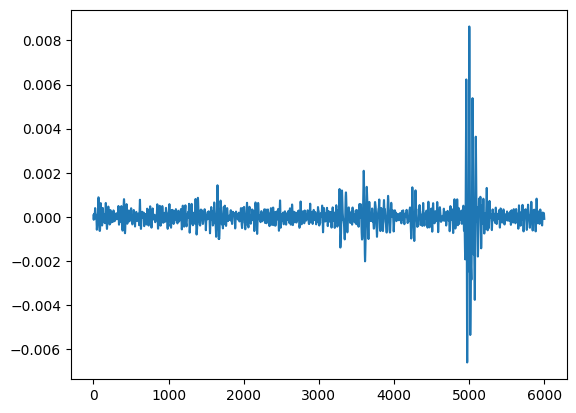

79 --------> 0.008244673190399397


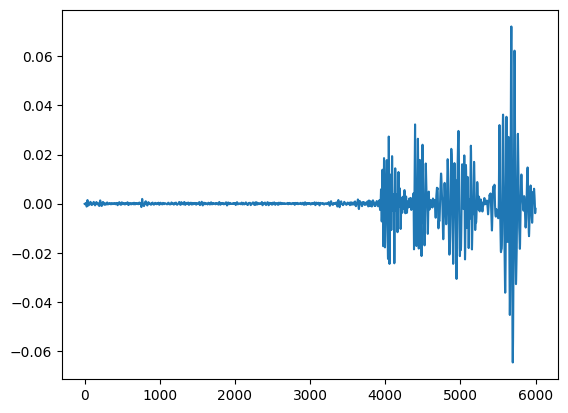

80 --------> 0.011570146017331476


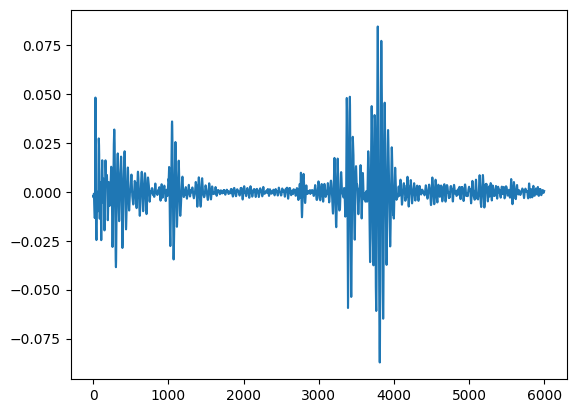

81 --------> 0.0012630466951165868


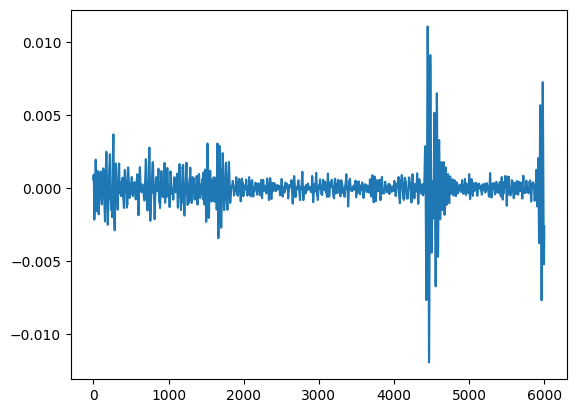

82 --------> 0.00497572864897384


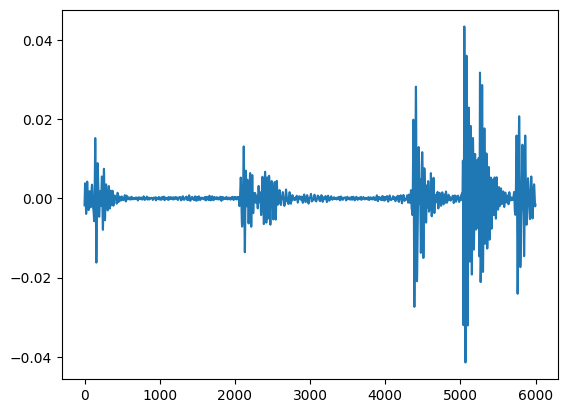

83 --------> 0.03045432782135023


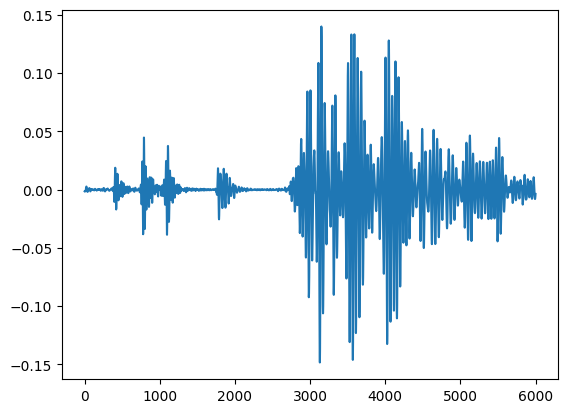

84 --------> 0.005202687798181374


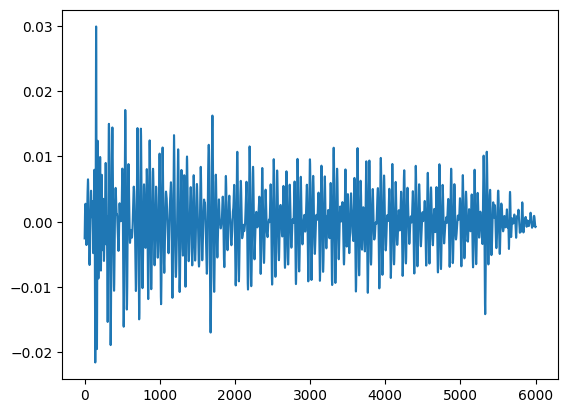

85 --------> 0.005441166819545062


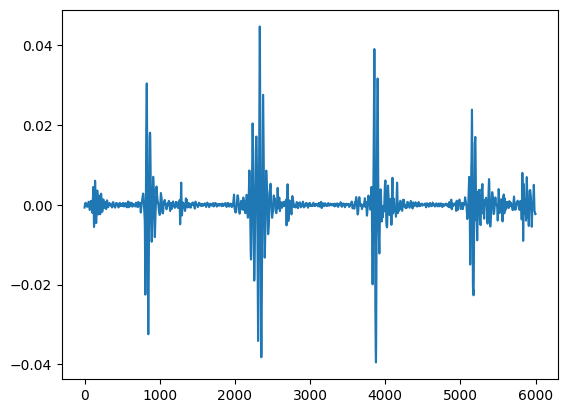

86 --------> 0.0024281093959346084


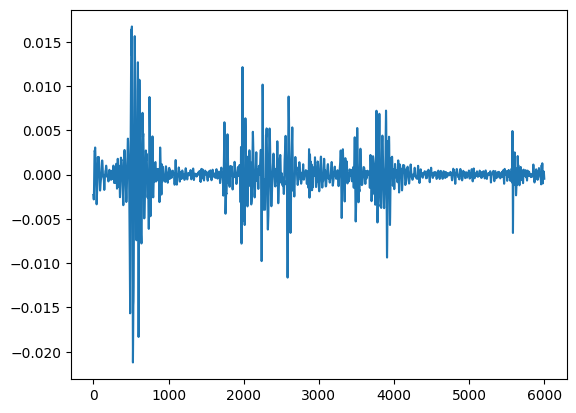

87 --------> 0.007845401110764797


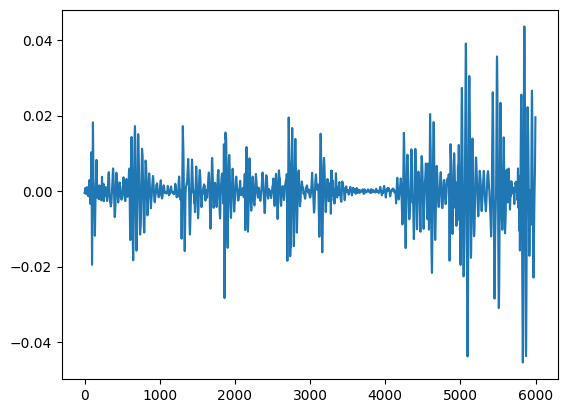

88 --------> 0.026969845617523205


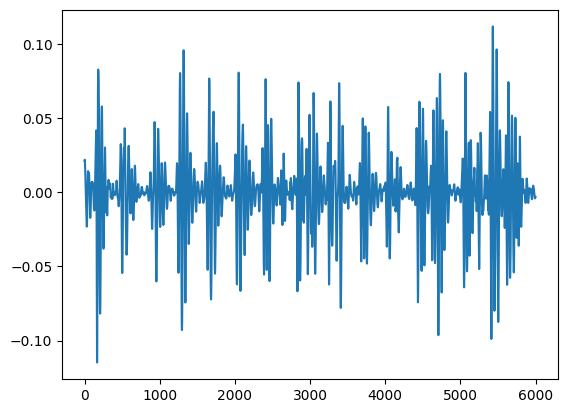

89 --------> 0.04184127568849544


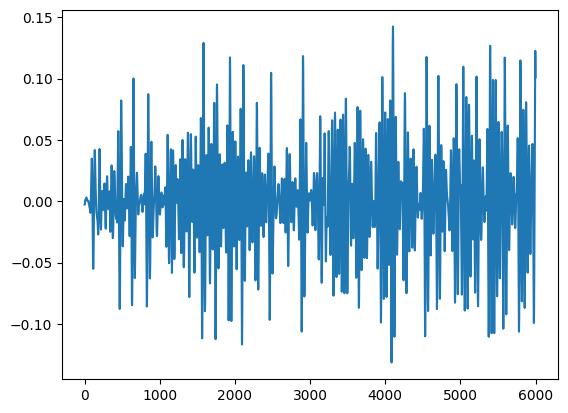

90 --------> 0.059598693272657835


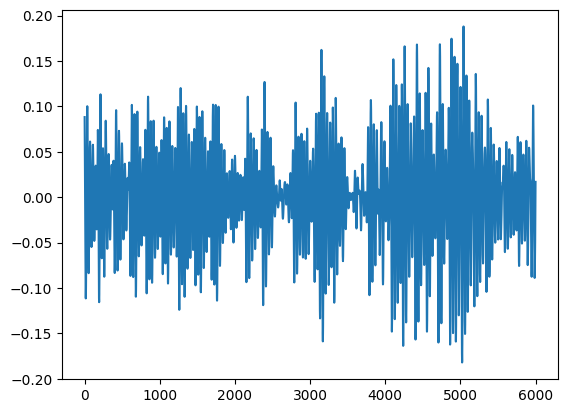

91 --------> 0.06740290304927007


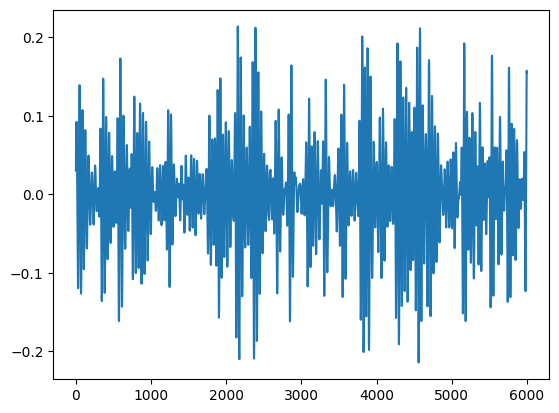

92 --------> 0.031676151135537525


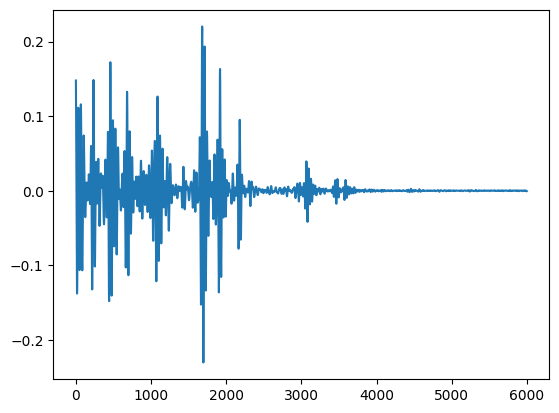

93 --------> 0.0008334417223068105


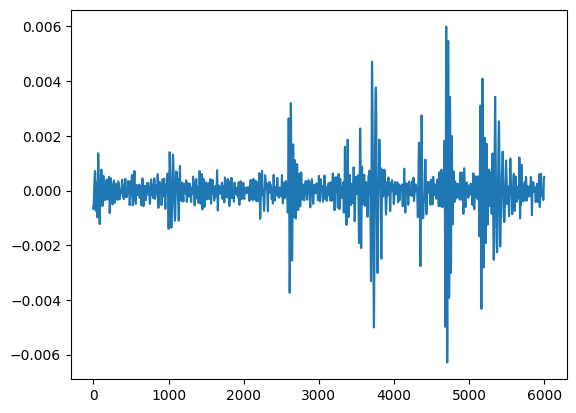

94 --------> 0.0007579149841126194


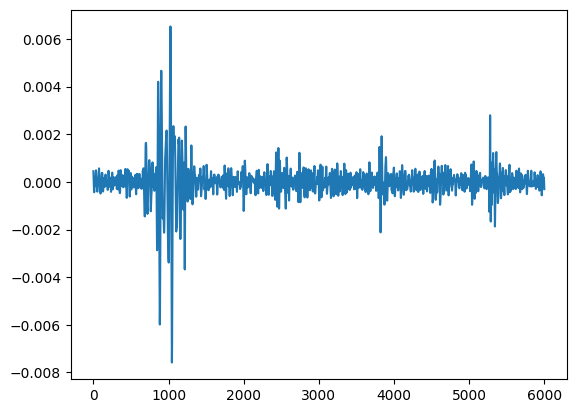

95 --------> 0.0009079149034992406


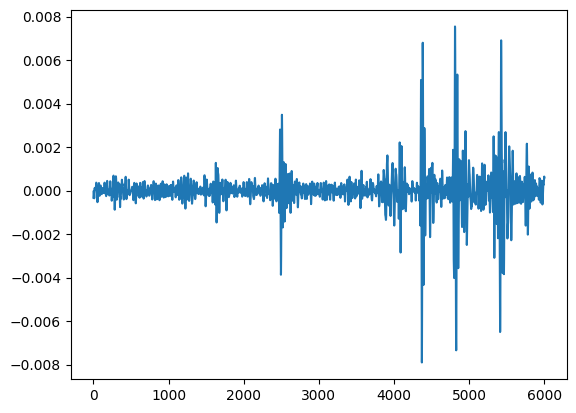

96 --------> 0.010392210654718593


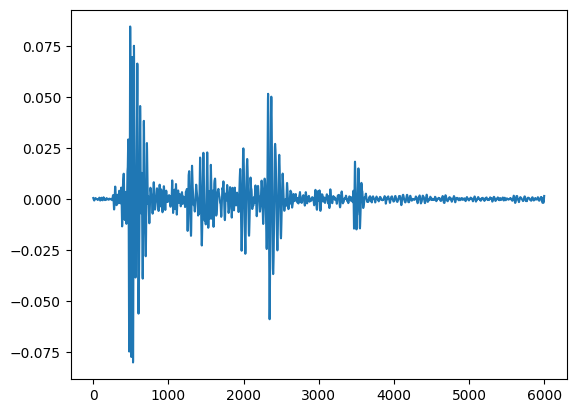

97 --------> 0.0022734794512055193


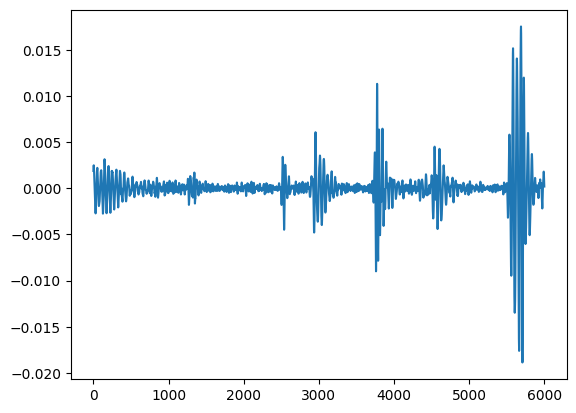

98 --------> 0.00028117713188450226


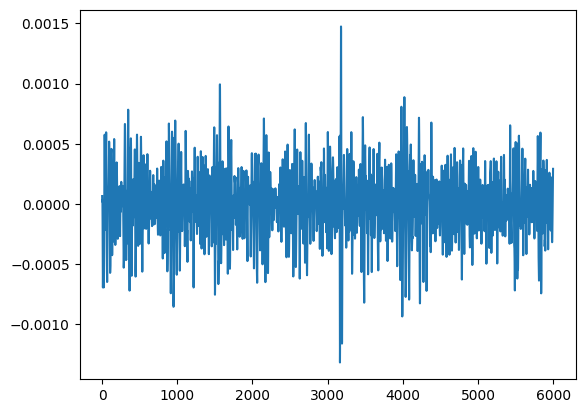

99 --------> 0.00046429458045522064


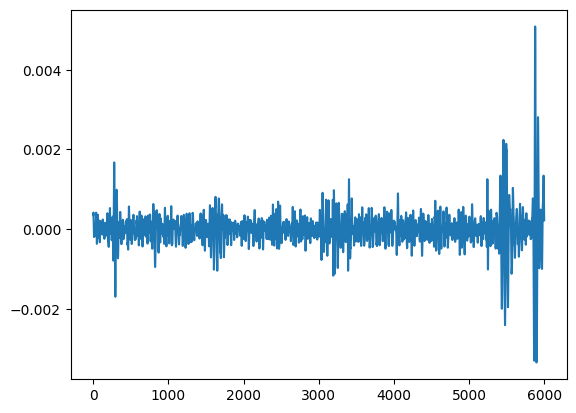

100 --------> 0.006453920573844599


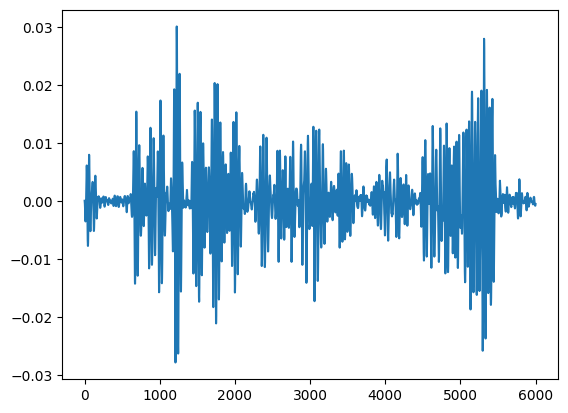

In [ ]:
for ii in range(len(x) // 6000):
# ipd.Audio(x[:6000], rate=sr) # load a NumPy array
# plt.plot(x[:6000])
  try:
    print(ii, '-------->', np.std(x[6000*ii:6000*(ii+1)]))
  except:
    pass

  plt.plot(x[6000*ii:6000*(ii+1)])
  plt.show()

  if ii >= 100:
    break


In [ ]:
ipd.Audio(x[100*100:100*101], rate=sr) # load a NumPy array

In [ ]:
ipd.Audio(input_audio[:50000], rate=sr) # load a NumPy array

In [ ]:
# wavfile.write("low_filtered.wav", sr, apply_lowpass_filter(input_audio, sr))
ipd.Audio(x[:50000], rate=sr) # load a NumPy array


In [ ]:
# model parameters
timesteps = 60
# sampling_frequency = 40
hidden_layer_units = 10

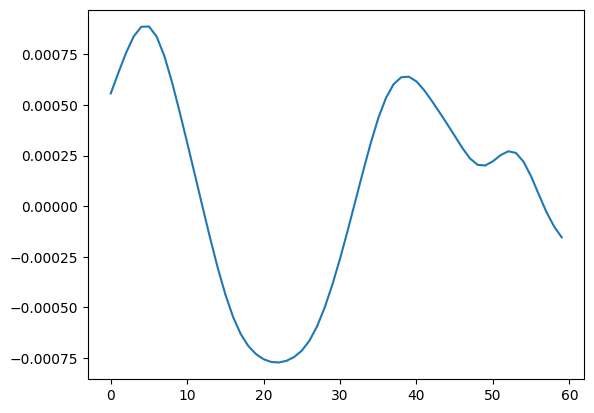

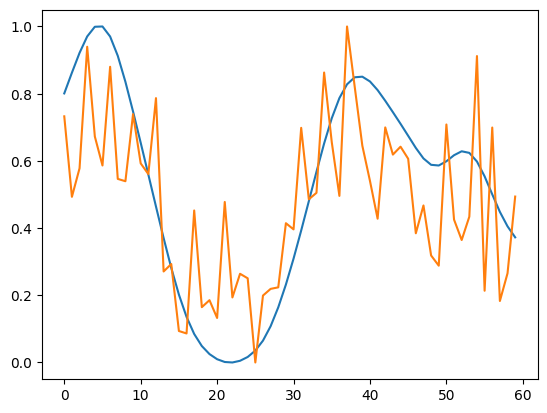

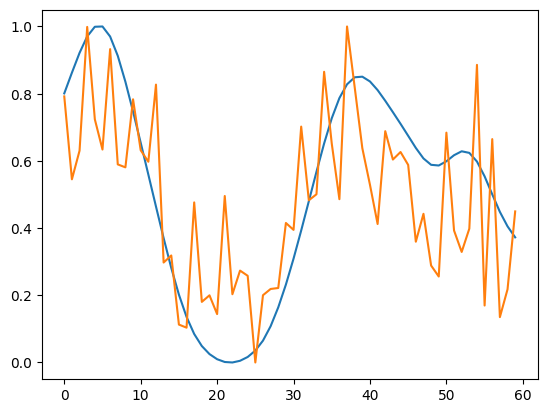

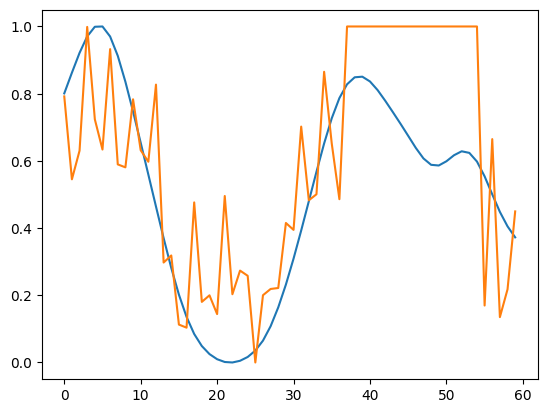

In [ ]:
def signal_extraction(data):
    train_input_data_list = []
    train_output_data_list = []

    # loop through the original dataset and perform data extraction/noise addition on each row
    for index in range(len(data) // timesteps):
        # separate the PPG segment in each row into timestep size
        # for index in range(0, 400-timesteps, timesteps):
        # print(index)

        if len(data) <= (index + timesteps):
            break

        if np.std(data[index:index + timesteps]) <= 0:
          continue

        # ---------- original data, normalized ----------

        a = data[index:index + timesteps].copy()
        a = a - np.min(a)
        a = a / np.max(a)

        # ---------- Gaussian noise data ----------
        noise1 = np.random.randn(len(a))/3
        b = a.copy() + noise1
        b = b - np.min(b)
        b = b / np.max(b)

        # ---------- Gaussian noise + low freq noise data ----------
        c = b.copy()
        slope = np.random.randn()
        for i in range(len(c)):
            c[i] = c[i] + slope/len(c)*i
            c = c - np.min(c)
            c = c / np.max(c)

        # ---------- Gaussian noise + low freq noise + saturation data ----------
        d = c.copy()
        location1 = np.random.randint(timesteps)
        location2 = location1 + np.random.randint(timesteps-location1)
        if np.random.rand() > 0:
            d[location1:location2] = np.ones(location2-location1, float)
        else:
            d[location1:location2] = np.zeros(location2-location1, float)


        # put 80% of the data into the training dataset list, and 20% into the validation dataset list
        # if datanum < 0.8 * len(data):
        if np.sum(np.isfinite(a))== len(a) and np.sum(np.isfinite(d))== len(d):
            train_input_data_list.append(d)  # CHANGE THIS TO THE NOISE-AUGMENTED DATA
            train_output_data_list.append(a)
    # else:
    #   if np.sum(np.isfinite(a))== len(a) and np.sum(np.isfinite(d))== len(d):
    #     val_input_data_list.append(d)  # CHANGE THIS TO THE NOISE-AUGMENTED DATA
    #     val_output_data_list.append(a)

    # plot the last data
    plt.figure()
    plt.plot(data[index:index + timesteps])
    plt.show()
    # plt.figure()
    plt.plot(a)
    plt.plot(b)
    plt.show()
    # plt.figure()
    plt.plot(a)
    plt.plot(c)
    plt.show()
    # plt.figure()
    plt.plot(a)
    plt.plot(d)
    plt.show()

    # convert the dataset lists into arrays
    train_input_data_list = np.asarray(train_input_data_list).reshape([-1, timesteps, 1])
    train_output_data_list = np.asarray(train_output_data_list)
    # val_input_data_list = np.asarray(val_input_data_list)
    # val_output_data_list = np.asarray(val_output_data_list)

    return train_input_data_list, train_output_data_list


[train_input_data_list, train_answer_data_list] = signal_extraction(apply_lowpass_filter(input_audio, sr))

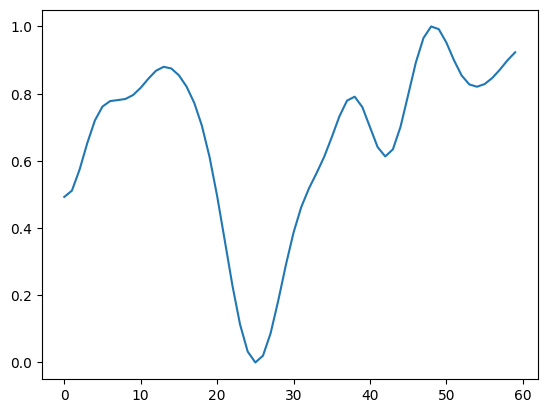

In [ ]:
plt.plot(train_answer_data_list[100000])

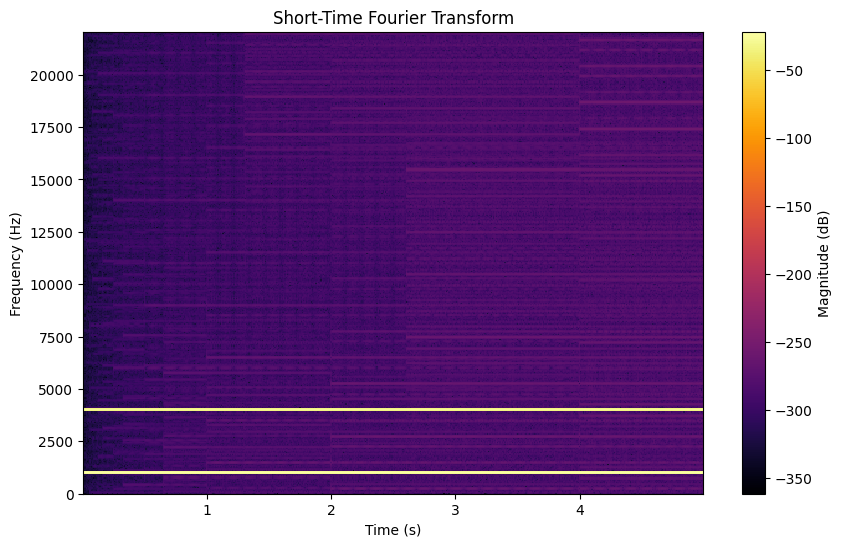

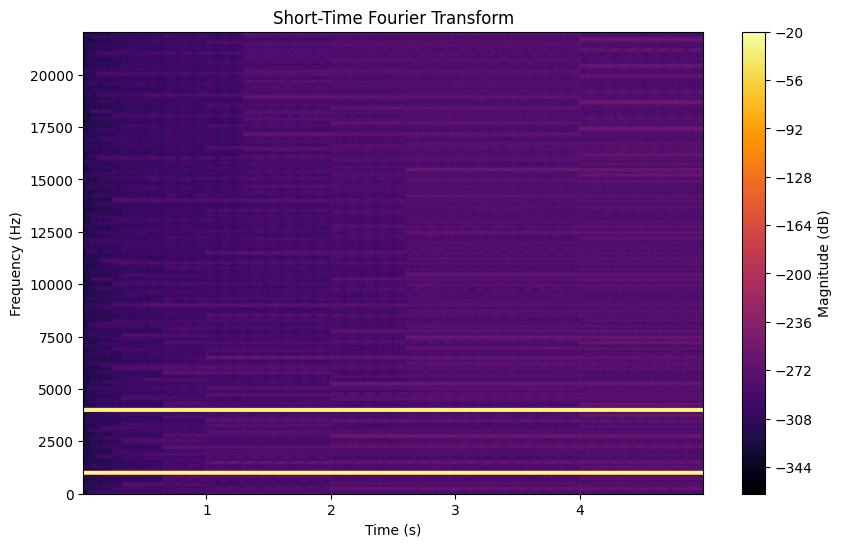

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# Generate a test signal
duration = 5  # Duration of the signal in seconds
fs = 44100  # Sampling rate
t = np.linspace(0, duration, duration * fs, endpoint=False)
f1 = 1000  # Frequency of the first sinusoid
f2 = 4000  # Frequency of the second sinusoid
x = np.sin(2 * np.pi * f1 * t) + 0.5 * np.sin(2 * np.pi * f2 * t)

# Compute the STFT
window_size = int(fs * 0.02)  # Size of the analysis window (20 ms)
hop_size = int(fs * 0.01)  # Hop size between consecutive windows (10 ms)
frequencies, times, magnitude = spectrogram(x, fs=fs, window='hann', nperseg=window_size, noverlap=hop_size)

# Plot the STFT as a mesh graph
plt.figure(figsize=(10, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(magnitude), shading='auto', cmap='inferno')
plt.colorbar(label='Magnitude (dB)')
plt.title('Short-Time Fourier Transform')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim(0, fs / 2)  # Limit the y-axis to the positive frequencies
plt.show()

# Plot the STFT as a contour plot
plt.figure(figsize=(10, 6))
plt.contourf(times, frequencies, 10 * np.log10(magnitude), levels=100, cmap='inferno')
plt.colorbar(label='Magnitude (dB)')
plt.title('Short-Time Fourier Transform')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim(0, fs / 2)  # Limit the y-axis to the positive frequencies
plt.show()


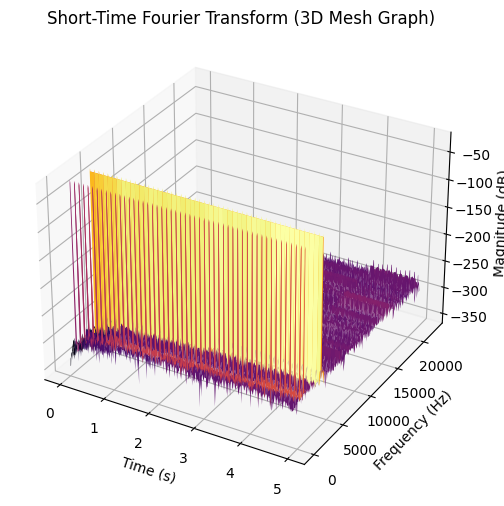

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from mpl_toolkits.mplot3d import Axes3D

# Generate a test signal
duration = 5  # Duration of the signal in seconds
fs = 44100  # Sampling rate
t = np.linspace(0, duration, duration * fs, endpoint=False)
f1 = 1000  # Frequency of the first sinusoid
f2 = 4000  # Frequency of the second sinusoid
x = np.sin(2 * np.pi * f1 * t) + 0.5 * np.sin(2 * np.pi * f2 * t)

# Compute the STFT
window_size = int(fs * 0.02)  # Size of the analysis window (20 ms)
hop_size = int(fs * 0.01)  # Hop size between consecutive windows (10 ms)
frequencies, times, magnitude = spectrogram(x, fs=fs, window='hann', nperseg=window_size, noverlap=hop_size)

# Plot the STFT as a 3D mesh graph
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
T, F = np.meshgrid(times, frequencies)
ax.plot_surface(T, F, 10 * np.log10(magnitude), cmap='inferno')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
ax.set_zlabel('Magnitude (dB)')
ax.set_title('Short-Time Fourier Transform (3D Mesh Graph)')
plt.show()


In [ ]:
import tensorflow as tf

def RNN():

    model_inputs = tf.keras.Input(shape=(timesteps, 1))
    encoding_layer = tf.keras.layers.LSTM(units=hidden_layer_units, activation='sigmoid', input_shape=(timesteps, 1))(model_inputs)
    out_layer = tf.keras.layers.Dense(units=timesteps, activation='sigmoid')(encoding_layer)

    model = tf.keras.Model(inputs=model_inputs, outputs=out_layer)

    return model

def BiRNN():

    model_inputs = tf.keras.Input(shape=(timesteps, 1))
    encoding_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=hidden_layer_units, activation='sigmoid', unroll=True, input_shape=(timesteps, 1)))(model_inputs)
    out_layer = tf.keras.layers.Dense(units=timesteps, activation='sigmoid')(encoding_layer)

    model = tf.keras.Model(inputs=model_inputs, outputs=out_layer)

    return model

def BiRNN_MM():

    model_inputs = tf.keras.Input(shape=(timesteps, 1))
    encoding_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=1, activation='sigmoid', input_shape=(timesteps, 1)))(model_inputs)
    out_layer = tf.keras.layers.Dense(units=timesteps, activation='sigmoid')(encoding_layer)

    model = tf.keras.Model(inputs=model_inputs, outputs=out_layer)

    return model


def build_denoising_autoencoder(input_shape):
    # model = tf.keras.models.Sequential()
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(256, activation='relu', input_shape=input_shape)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    # Decoder
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(input_shape[0] * input_shape[1], activation='sigmoid')(x)
    x = tf.keras.layers.Reshape((input_shape[0], input_shape[1]))(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)

    return model

In [ ]:
# DAE = BiRNN()
DAE = build_denoising_autoencoder(train_input_data_list.shape[1:])
DAE.compile(optimizer='adam', loss='mse')

In [ ]:
with tf.device(f"/device:GPU:0"):
  DAE.fit(train_input_data_list, train_answer_data_list,
          epochs=30,
          batch_size=32,
          shuffle=True,
          # validation_data=(val_input_data_list, val_answer_data_list), verbose=2, callbacks=[cp_callback]
          )


Epoch 1/30
18452/18452 [==============================] - 62s 3ms/step - loss: 0.0570
Epoch 2/30
18452/18452 [==============================] - 53s 3ms/step - loss: 0.0522
Epoch 3/30
18452/18452 [==============================] - 54s 3ms/step - loss: 0.0510
Epoch 4/30
18452/18452 [==============================] - 54s 3ms/step - loss: 0.0504
Epoch 5/30
18452/18452 [==============================] - 54s 3ms/step - loss: 0.0499
Epoch 6/30
18452/18452 [==============================] - 54s 3ms/step - loss: 0.0495
Epoch 7/30
18452/18452 [==============================] - 54s 3ms/step - loss: 0.0493
Epoch 8/30
18452/18452 [==============================] - 54s 3ms/step - loss: 0.0491
Epoch 9/30
18452/18452 [==============================] - 54s 3ms/step - loss: 0.0489
Epoch 10/30
18452/18452 [==============================] - 54s 3ms/step - loss: 0.0487
Epoch 11/30
18452/18452 [==============================] - 53s 3ms/step - loss: 0.0486
Epoch 12/30
18452/18452 [===========================

In [ ]:
DAE.save(f'/content/drive/MyDrive/Colab_Notebooks/denoise/DAE_model.h5')

In [ ]:
train_answer_data_list[0].shape

(60,)

In [ ]:
pred = DAE.predict(train_input_data_list, batch_size=32)

18452/18452 [==============================] - 26s 1ms/step


In [ ]:
# pred.shape
# data_sig = np.array([] )
data_sig = []
for pp in pred:
  # data_sig = np.concatenate([data_sig, pp], axis=1)
  data_sig.extend(pp)


In [ ]:
data_sig1 = np.array(data_sig)
data_sig1.shape

(35426760, 1)

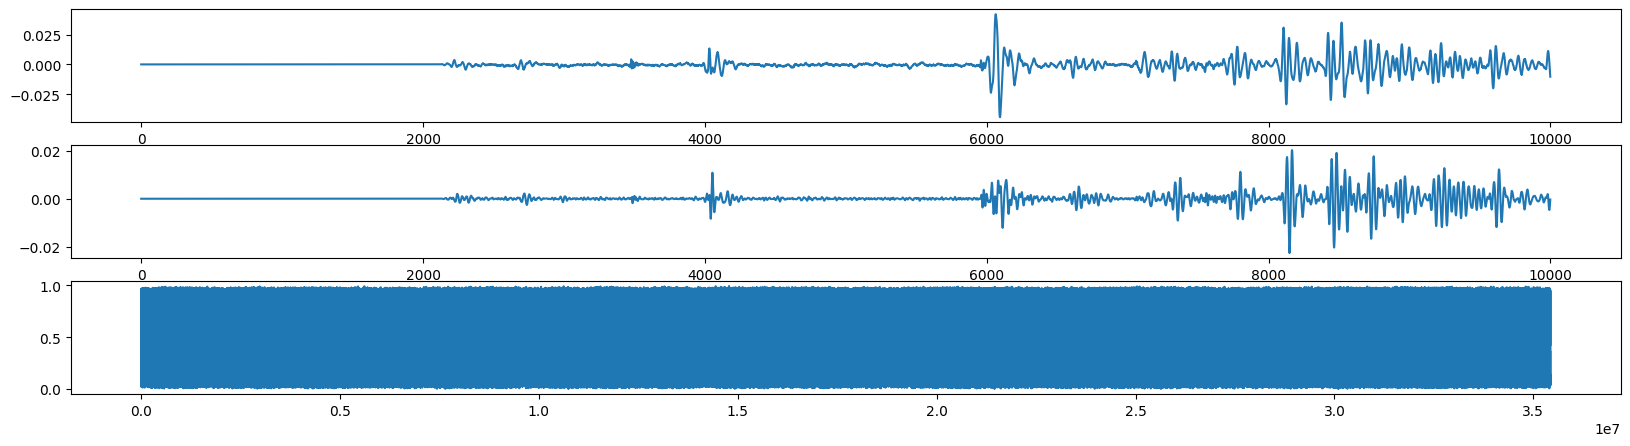

In [ ]:
plt.figure(figsize=(20, 5))

plt.subplot(3, 1, 1)
plt.plot(input_audio[:10000])

plt.subplot(3, 1, 2)
plt.plot(apply_lowpass_filter(input_audio, sr)[:10000])

plt.subplot(3, 1, 3)
plt.plot(data_sig1)
plt.show()

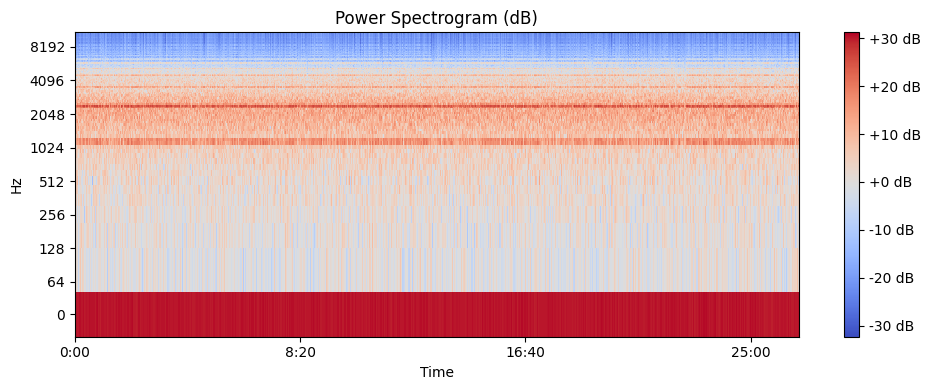

In [ ]:
# Compute the power spectrogram
power_spec = librosa.feature.melspectrogram(y=data_sig1, sr=sr, n_fft=2048, hop_length=512)

# Convert power spectrogram to dB scale
power_db = librosa.power_to_db(power_spec)

# Display the power spectrogram in dB
plt.figure(figsize=(10, 4))
librosa.display.specshow(power_db, sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Power Spectrogram (dB)')
plt.tight_layout()
plt.show()

In [ ]:
data_sig2 = apply_lowpass_filter(data_sig1, sr)

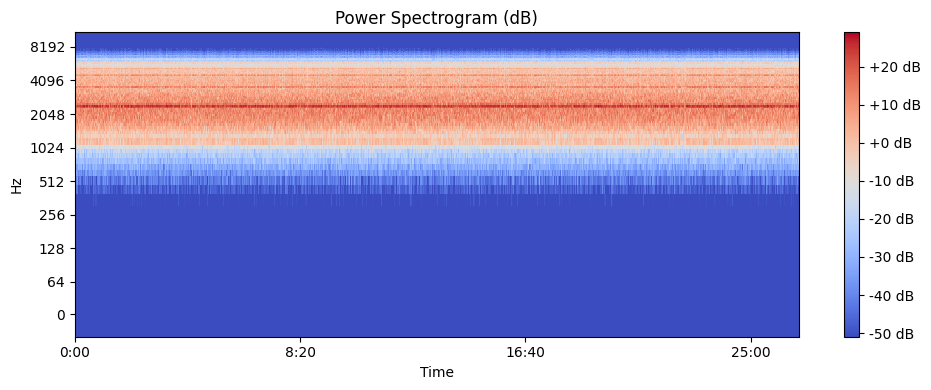

In [ ]:
# Compute the power spectrogram
power_spec = librosa.feature.melspectrogram(y=data_sig2, sr=sr, n_fft=2048, hop_length=512)

# Convert power spectrogram to dB scale
power_db = librosa.power_to_db(power_spec)

# Display the power spectrogram in dB
plt.figure(figsize=(10, 4))
librosa.display.specshow(power_db, sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Power Spectrogram (dB)')
plt.tight_layout()
plt.show()

In [ ]:
wavfile.write("/Users/sehwan/Desktop/datasets/bowel_sound/original.wav", sample_rate, data)
wavfile.write("/Users/sehwan/Desktop/datasets/bowel_sound/filtered.wav", sample_rate, filtered_signal)
